In [ ]:
#Find number of hidden units and layers for Cross-Entropy loss function 

library(h2o)
localH2O<- h2o.init()

#this function does not actually exist
#h2o.addFunction(localH2O, function(x) { 1/(1+exp(-x)) }, "Logsig")

#Import the data from the website repository, first name the path
train_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra"
test_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes"

#give path to the importFile command in R
train1 <- h2o.importFile(train_file)
test <- h2o.importFile(test_file)

#get summary of data
#summary(train)
#summary(test)

#get a vector of the number of instances and the length of the feature vectors
dtrain <- dim(train1)
dtest <- dim(test)

#split training data at random for a selection to train on and a selection to validate hyperparameters
splits <- h2o.splitFrame(train1, c(0.8), seed=1385)
train <- h2o.assign(splits[[1]], "train.hex")
valid <- h2o.assign(splits[[2]], "valid.hex")

#can do some initial data inspection using, C65 is the labeled category
#par(mfrow=c(1,1))
#plot(h2o.tabulate(train, "C40", "C65"))
#plot(h2o.tabulate(train, "C30", "C65"))


#treat vectors as integer categories(factors), and thus not factors
train <- as.factor(train)
valid <- as.factor(valid)
test <- as.factor(test)

#set the target and feature(predictor) vectors
response <- "C65"
predictors <- setdiff(names(train1), response)
predictors

#set parameters for the hidden layers search, with low learning rate, e.g. the 0.01
#set layers as 1,2,5,8,10
layers <- c(1,2,5,8,10)
#set units per layer as 60,50,40,30,20,10
units <- c(60,50,40,30,20,10)
hiddenlist <- list()
for (i in 1:length(layers)){
    for (j in 1:length(units)){
        hiddenlist[[length(hiddenlist)+1]] <- rep_len(units[j],layers[i])
    }}
#give a string index for all of these lists
#choose hidden layers, by looping over a set of them
#extract convergence rate and accuracy
#do study on learning rate for both tanh, and Rectifier for the hyperparameters

#give initial lists
explist <- list()
accuracylist <- list()
vmselist <- list()
trmselist <- list()
stoplist <- list()

count=1

for (i in 1:length(layers)){
    for (j in 1:length(units)){
        #automatically uses softmax output
        m1 <- h2o.deeplearning(
            model_id="dl_model_first", 
            training_frame=train, 
            validation_frame=valid,   ## validation dataset: used for scoring and early stopping
            x=predictors,
            y=response,
            #hidden=c(200,200),       ## default: 2 hidden layers with 200 neurons each
            epochs=1000,                ##  controls stopping times
            #variable_importances=T,    ## not enabled by default
            distribution = "multinomial", ##  we have categorical data
            standardize = T,  ## standardize the input data
            activation = "Tanh",  ## may choose Tanh or Rectifier, i.e. ReLU. Logistic sigmoid not included
            categorical_encoding="OneHotInternal",  ## this ensures the use of the 1 of c encoding with "OneHotInternal"
            loss = "CrossEntropy",  ## can be "Quadratic" or "CrossEntropy"
            adaptive_rate = F, ##turn adaptive rate adjustments off
            rate = 0.01, #the learning rate, start around 0.5, should be positive
            #to reduce number of hyper parameters we will do this so that 
            momentum_start = 0.0, #the momentum at the start, overall must be 0<\alpha<1
            momentum_ramp = 1, #the number of samples overwhich the ramp occurs
            momentum_stable = 0.0, #the stable momentum, should be again less than 1 and greater than 0
            #train_samples_per_iteration = 0, #number of training samples per mapreduce iteraton, 
            #special vals 0 one epoch, -1 all available data, -2 autotuning
            #want to disable early stopping
            classification_stop = -1,
            regression_stop = -1,
            overwrite_with_best_model=FALSE,  #don't save the best model
            hidden=unlist(hiddenlist[count])#c(50,50) ## hidden layers c(100,100) 2 hidden layers with 100 neurons each
        )
        
        #find the convergence statistics for the 
        #find performance statistics i.e. accuracy for the training set
        #m2 = h2o.performance(m1, newdata=test, train=FALSE, valid=FALSE, xval=FALSE)
        Mat = h2o.confusionMatrix(m1, newdata=test, valid=FALSE)
        #accuracy on the training case
        accuracy = 1-tail(Mat$Error, n=1)
        
        #final mean squared error for the training and validation sets
        vmse <- h2o.mse(m1, valid=TRUE, train=FALSE)
        trmse <- h2o.mse(m1, valid=FALSE, train=TRUE)

        #now fit the convergence with a power law
        tr <- m1@model$scoring_history$training_rmse
        v <- m1@model$scoring_history$validation_rmse
        ep <- m1@model$scoring_history$epochs

        fit <- lm(log(ep)~log(tr))
        pow <- summary(fit)$coefficients[2,1]
        exp <- 1/pow
        
        #put everything in a list
        explist[[length(explist)+1]] <- exp
        accuracylist[[length(accuracylist)+1]] <- accuracy
        vmselist[[length(vmselist)+1]] <- vmse
        trmselist[[length(trmselist)+1]] <- trmse
        stoplist[[length(stoplist)+1]]  <- tail(ep, n=1)
        count
        count <- count+1
        }}

png(file = "ClassAcc_vHidden_ClassAcc_CrossEnt.jpg")
#plot the accuracy of everything
acc <- unlist(accuracylist)
Macc <- matrix(acc, nrow=length(layers), ncol=length(units), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0.85,0.95), xlim=c(10,60), xlab = "Hidden units", ylab="Accuracy", main ="Classification Accuracy")
lines(units, Macc[1,1:length(units)], type = "o", col = "red")
lines(units, Macc[2,1:length(units)], type = "o", col = "blue")
lines(units, Macc[3,1:length(units)], type = "o", col = "black")
lines(units, Macc[4,1:length(units)], type = "o", col = "orange")
lines(units, Macc[5,1:length(units)], type = "o", col = "green")
legend(40, 0.89, c("1-layer", "2-layer","5-layer","8-layer","10-layer"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()

png(file = "ClassAcc_vHidden_ConvExp_CrossEnt.jpg")
#plot the convergence rate of it all
expon <- unlist(explist)
Mexp <- matrix(expon, nrow=length(layers), ncol=length(units), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(-3,0), xlim=c(10,60), xlab = "Hidden units", ylab="Exponent", main ="Convergence Rate Exponent for the Training MSE")
lines(units, Mexp[1,1:length(units)], type = "o", col = "red")
lines(units, Mexp[2,1:length(units)], type = "o", col = "blue")
lines(units, Mexp[3,1:length(units)], type = "o", col = "black")
lines(units, Mexp[4,1:length(units)], type = "o", col = "orange")
lines(units, Mexp[5,1:length(units)], type = "o", col = "green")
legend(40, -0.2, c("1-layer", "2-layer","5-layer","8-layer","10-layer"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()       

png(file = "ClassAcc_vHidden_MSEval_CrossEnt.jpg")
#plot the MSE for the validation case at the last iteration
vmse2 <- unlist(vmselist)
Mvmse <- matrix(vmse2, nrow=length(layers), ncol=length(units), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0,0.5), xlim=c(10,60), xlab = "Hidden units", ylab="MSE", main ="MSE for the Validation Set")
lines(units, Mvmse[1,1:length(units)], type = "o", col = "red")
lines(units, Mvmse[2,1:length(units)], type = "o", col = "blue")
lines(units, Mvmse[3,1:length(units)], type = "o", col = "black")
lines(units, Mvmse[4,1:length(units)], type = "o", col = "orange")
lines(units, Mvmse[5,1:length(units)], type = "o", col = "green")
legend(40, 0.35, c("1-layer", "2-layer","5-layer","8-layer","10-layer"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()    

png(file = "ClassAcc_vHidden_Stop_CrossEnt.jpg")
#plot the MSE for the validation case at the last iteration
stop <- unlist(stoplist)
Mstop <- matrix(stop, nrow=length(layers), ncol=length(units), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(1,1000), xlim=c(10,60), log="xy", xlab = "Hidden units", ylab="Stopping Epoch", main ="Early Stopping Time")
lines(units, Mstop[1,1:length(units)], type = "o", col = "red")
lines(units, Mstop[2,1:length(units)], type = "o", col = "blue")
lines(units, Mstop[3,1:length(units)], type = "o", col = "black")
lines(units, Mstop[4,1:length(units)], type = "o", col = "orange")
lines(units, Mstop[5,1:length(units)], type = "o", col = "green")
legend(20, 50, c("1-layer", "2-layer","5-layer","8-layer","10-layer"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()        

#summary(m1)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         46 minutes 24 seconds 
    H2O cluster version:        3.10.3.6 
    H2O cluster version age:    9 days  
    H2O cluster name:           H2O_started_from_R_ejmurphy_ara819 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.65 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.2 (2016-10-31) 

  |======================================================================| 100%
  |======================================================================| 100%


[1] "C1"  "C2"  "C3"  "C4"  "C5"  "C6"  "C7"  "C8"  "C9"  "C10" "C11" "C12"
[13] "C13" "C14" "C15" "C16" "C17" "C18" "C19" "C20" "C21" "C22" "C23" "C24"
[25] "C25" "C26" "C27" "C28" "C29" "C30" "C31" "C32" "C33" "C34" "C35" "C36"
[37] "C37" "C38" "C39" "C40" "C41" "C42" "C43" "C44" "C45" "C46" "C47" "C48"
[49] "C49" "C50" "C51" "C52" "C53" "C54" "C55" "C56" "C57" "C58" "C59" "C60"
[61] "C61" "C62" "C63" "C64"

Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\ejmurphy\AppData\Local\Temp\RtmpMHVodK/h2o_ejmurphy_started_from_r.out
    C:\Users\ejmurphy\AppData\Local\Temp\RtmpMHVodK/h2o_ejmurphy_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 469 milliseconds 
    H2O cluster version:        3.10.3.6 
    H2O cluster version age:    9 days  
    H2O cluster name:           H2O_started_from_R_ejmurphy_spv787 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.75 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.2 (2016-10-31) 

Note:  As started, H2O is limited to the CRAN default of

[1] "C1"  "C2"  "C3"  "C4"  "C5"  "C6"  "C7"  "C8"  "C9"  "C10" "C11" "C12"
[13] "C13" "C14" "C15" "C16" "C17" "C18" "C19" "C20" "C21" "C22" "C23" "C24"
[25] "C25" "C26" "C27" "C28" "C29" "C30" "C31" "C32" "C33" "C34" "C35" "C36"
[37] "C37" "C38" "C39" "C40" "C41" "C42" "C43" "C44" "C45" "C46" "C47" "C48"
[49] "C49" "C50" "C51" "C52" "C53" "C54" "C55" "C56" "C57" "C58" "C59" "C60"
[61] "C61" "C62" "C63" "C64"

Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


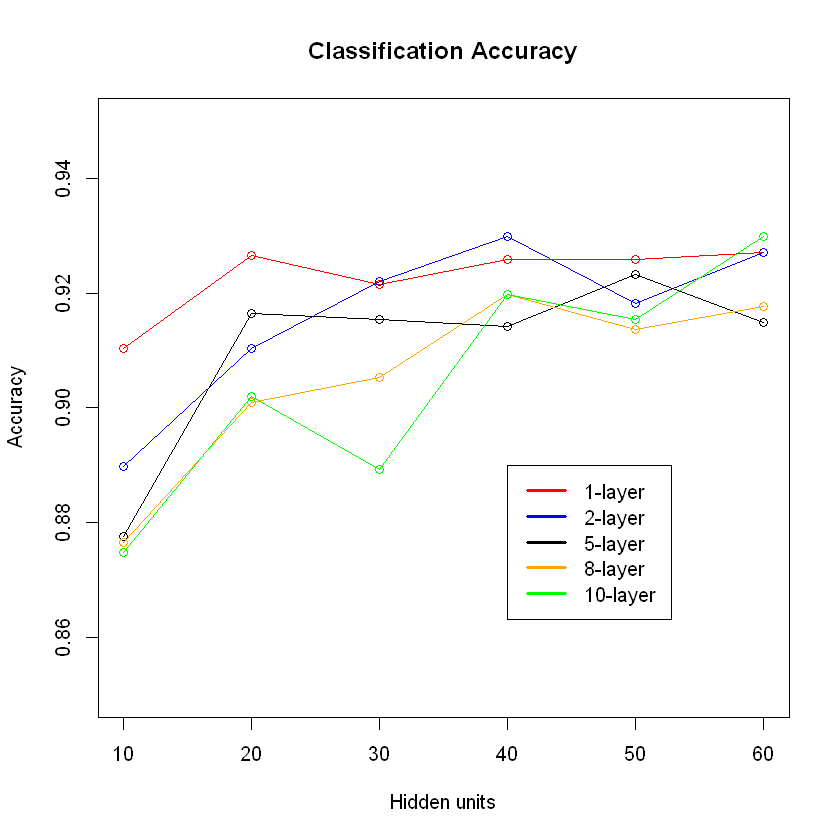

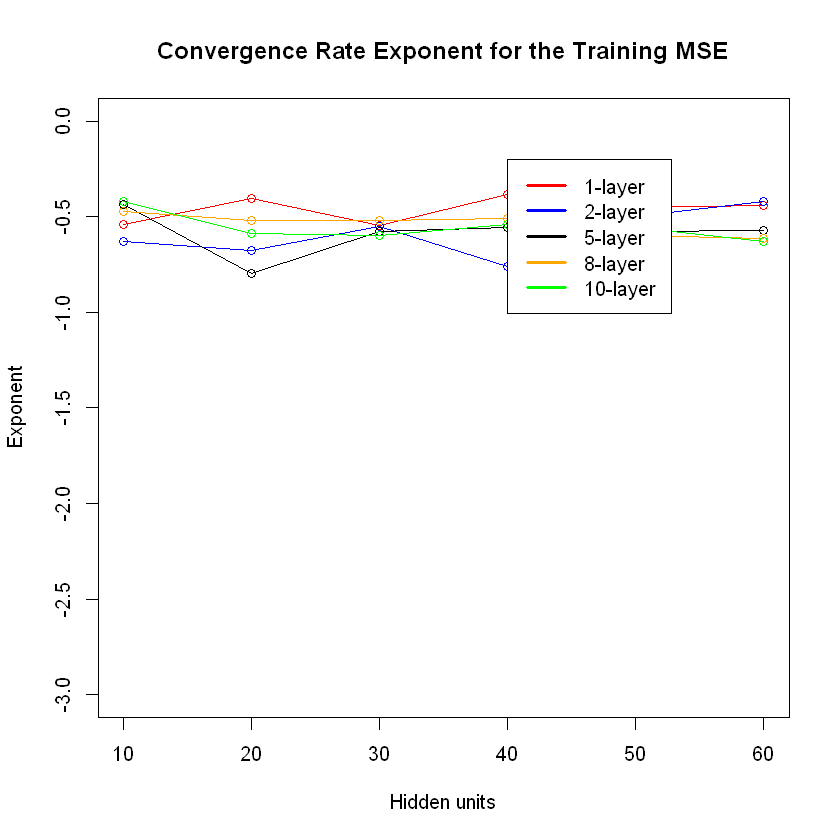

Warning message in is.na(y):
"is.na() applied to non-(list or vector) of type 'NULL'"

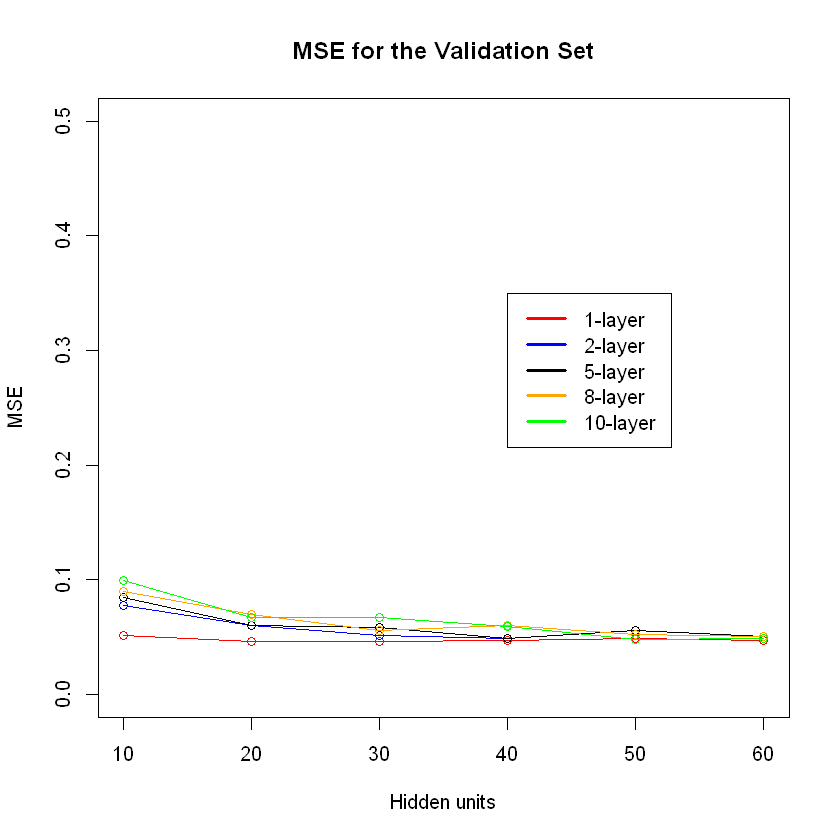

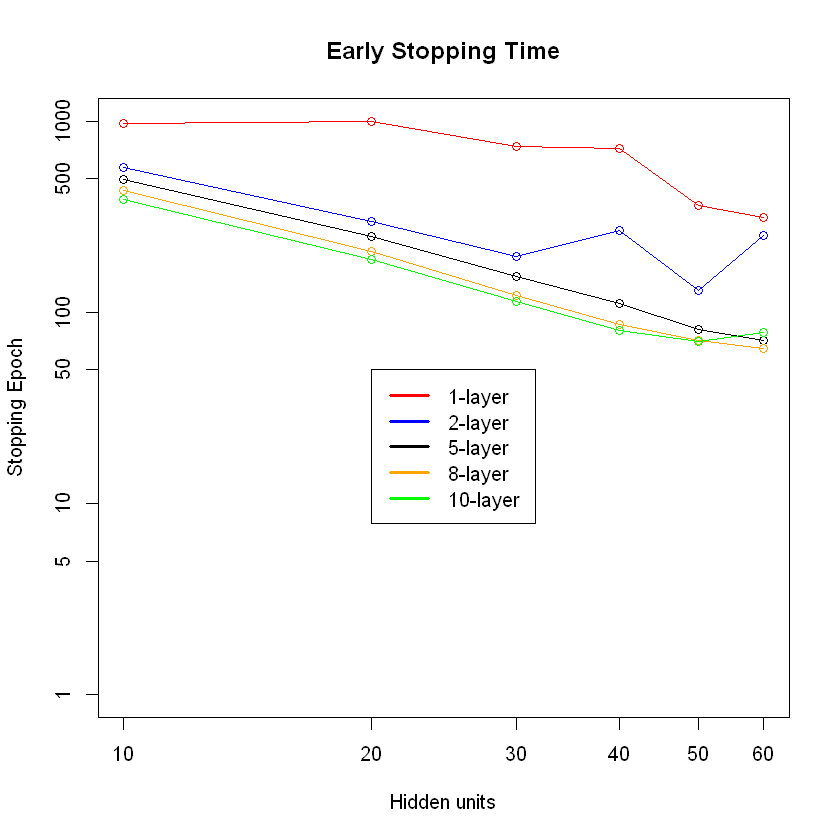

In [2]:
#Find number of hidden units and layers for Quadratic loss function 
library(h2o)
localH2O<- h2o.init()

#this function does not actually exist
#h2o.addFunction(localH2O, function(x) { 1/(1+exp(-x)) }, "Logsig")

#Import the data from the website repository, first name the path
train_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra"
test_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes"

#give path to the importFile command in R
train1 <- h2o.importFile(train_file)
test <- h2o.importFile(test_file)

#get summary of data
#summary(train)
#summary(test)

#get a vector of the number of instances and the length of the feature vectors
dtrain <- dim(train1)
dtest <- dim(test)

#split training data at random for a selection to train on and a selection to validate hyperparameters
splits <- h2o.splitFrame(train1, c(0.8), seed=1385)
train <- h2o.assign(splits[[1]], "train.hex")
valid <- h2o.assign(splits[[2]], "valid.hex")

#can do some initial data inspection using, C65 is the labeled category
#par(mfrow=c(1,1))
#plot(h2o.tabulate(train, "C40", "C65"))
#plot(h2o.tabulate(train, "C30", "C65"))


#treat vectors as integer categories(factors), and thus not factors
train <- as.factor(train)
valid <- as.factor(valid)
test <- as.factor(test)

#set the target and feature(predictor) vectors
response <- "C65"
predictors <- setdiff(names(train1), response)
predictors

#set parameters for the hidden layers search, with low learning rate, e.g. the 0.01
#set layers as 1,2,5,8,10
layers <- c(1,2,5,8,10)
#set units per layer as 60,50,40,30,20,10
units <- c(60,50,40,30,20,10)
hiddenlist <- list()
for (i in 1:length(layers)){
    for (j in 1:length(units)){
        hiddenlist[[length(hiddenlist)+1]] <- rep_len(units[j],layers[i])
    }}
#give a string index for all of these lists
#choose hidden layers, by looping over a set of them
#extract convergence rate and accuracy
#do study on learning rate for both tanh, and Rectifier for the hyperparameters

#give initial lists
explist <- list()
accuracylist <- list()
vmselist <- list()
trmselist <- list()
stoplist <- list()

count=1

for (i in 1:length(layers)){
    for (j in 1:length(units)){
        #automatically uses softmax output
        m1 <- h2o.deeplearning(
            model_id="dl_model_first", 
            training_frame=train, 
            validation_frame=valid,   ## validation dataset: used for scoring and early stopping
            x=predictors,
            y=response,
            #hidden=c(200,200),       ## default: 2 hidden layers with 200 neurons each
            epochs=1000,                ##  controls stopping times
            #variable_importances=T,    ## not enabled by default
            distribution = "multinomial", ##  we have categorical data
            standardize = T,  ## standardize the input data
            activation = "Tanh",  ## may choose Tanh or Rectifier, i.e. ReLU. Logistic sigmoid not included
            categorical_encoding="OneHotInternal",  ## this ensures the use of the 1 of c encoding with "OneHotInternal"
            loss = "Quadratic",  ## can be "Quadratic" or "CrossEntropy"
            adaptive_rate = F, ##turn adaptive rate adjustments off
            rate = 0.01, #the learning rate, start around 0.5, should be positive
            #to reduce number of hyper parameters we will do this so that 
            momentum_start = 0.0, #the momentum at the start, overall must be 0<\alpha<1
            momentum_ramp = 1, #the number of samples overwhich the ramp occurs
            momentum_stable = 0.0, #the stable momentum, should be again less than 1 and greater than 0
            #train_samples_per_iteration = 0, #number of training samples per mapreduce iteraton, 
            #special vals 0 one epoch, -1 all available data, -2 autotuning
            #want to disable early stopping
            classification_stop = -1,
            regression_stop = -1,
            overwrite_with_best_model=FALSE,  #don't save the best model
            hidden=unlist(hiddenlist[count])#c(50,50) ## hidden layers c(100,100) 2 hidden layers with 100 neurons each
        )
        
        #find the convergence statistics for the 
        #find performance statistics i.e. accuracy for the training set
        #m2 = h2o.performance(m1, newdata=test, train=FALSE, valid=FALSE, xval=FALSE)
        Mat = h2o.confusionMatrix(m1, newdata=test, valid=FALSE)
        #accuracy on the training case
        accuracy = 1-tail(Mat$Error, n=1)
        
        #final mean squared error for the training and validation sets
        vmse <- h2o.mse(m1, valid=TRUE, train=FALSE)
        trmse <- h2o.mse(m1, valid=FALSE, train=TRUE)

        #now fit the convergence with a power law
        tr <- m1@model$scoring_history$training_rmse
        v <- m1@model$scoring_history$validation_rmse
        ep <- m1@model$scoring_history$epochs

        fit <- lm(log(ep)~log(tr))
        pow <- summary(fit)$coefficients[2,1]
        exp <- 1/pow
        
        #put everything in a list
        explist[[length(explist)+1]] <- exp
        accuracylist[[length(accuracylist)+1]] <- accuracy
        vmselist[[length(vmselist)+1]] <- vmse
        trmselist[[length(trmselist)+1]] <- trmse
        stoplist[[length(stoplist)+1]]  <- tail(ep, n=1)
        count
        count <- count+1
        }}

png(file = "ClassAcc_vHidden_ClassAcc_Quad.jpg")
#plot the accuracy of everything
acc <- unlist(accuracylist)
Macc <- matrix(acc, nrow=length(layers), ncol=length(units), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0.85,0.95), xlim=c(10,60), xlab = "Hidden units", ylab="Accuracy", main ="Classification Accuracy")
lines(units, Macc[1,1:length(units)], type = "o", col = "red")
lines(units, Macc[2,1:length(units)], type = "o", col = "blue")
lines(units, Macc[3,1:length(units)], type = "o", col = "black")
lines(units, Macc[4,1:length(units)], type = "o", col = "orange")
lines(units, Macc[5,1:length(units)], type = "o", col = "green")
legend(40, 0.89, c("1-layer", "2-layer","5-layer","8-layer","10-layer"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()

png(file = "ClassAcc_vHidden_ConvExp_Quad.jpg")
#plot the convergence rate of it all
expon <- unlist(explist)
Mexp <- matrix(expon, nrow=length(layers), ncol=length(units), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(-3,0), xlim=c(10,60), xlab = "Hidden units", ylab="Exponent", main ="Convergence Rate Exponent for the Training MSE")
lines(units, Mexp[1,1:length(units)], type = "o", col = "red")
lines(units, Mexp[2,1:length(units)], type = "o", col = "blue")
lines(units, Mexp[3,1:length(units)], type = "o", col = "black")
lines(units, Mexp[4,1:length(units)], type = "o", col = "orange")
lines(units, Mexp[5,1:length(units)], type = "o", col = "green")
legend(40, -1.5, c("1-layer", "2-layer","5-layer","8-layer","10-layer"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()       

png(file = "ClassAcc_vHidden_MSEval_Quad.jpg")
#plot the MSE for the validation case at the last iteration
vmse2 <- unlist(vmselist)
Mvmse <- matrix(vmse2, nrow=length(layers), ncol=length(units), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0,0.15), xlim=c(10,60), xlab = "Hidden units", ylab="MSE", main ="MSE for the Validation Set")
lines(units, Mvmse[1,1:length(units)], type = "o", col = "red")
lines(units, Mvmse[2,1:length(units)], type = "o", col = "blue")
lines(units, Mvmse[3,1:length(units)], type = "o", col = "black")
lines(units, Mvmse[4,1:length(units)], type = "o", col = "orange")
lines(units, Mvmse[5,1:length(units)], type = "o", col = "green")
legend(40, 0.15, c("1-layer", "2-layer","5-layer","8-layer","10-layer"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()    

png(file = "ClassAcc_vHidden_Stop_Quad.jpg")
#plot the MSE for the validation case at the last iteration
stop <- unlist(stoplist)
Mstop <- matrix(stop, nrow=length(layers), ncol=length(units), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(1,1000), xlim=c(10,60), log="xy", xlab = "Hidden units", ylab="Stopping Epoch", main ="Early Stopping Time")
lines(units, Mstop[1,1:length(units)], type = "o", col = "red")
lines(units, Mstop[2,1:length(units)], type = "o", col = "blue")
lines(units, Mstop[3,1:length(units)], type = "o", col = "black")
lines(units, Mstop[4,1:length(units)], type = "o", col = "orange")
lines(units, Mstop[5,1:length(units)], type = "o", col = "green")
legend(20, 50, c("1-layer", "2-layer","5-layer","8-layer","10-layer"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()  

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         9 minutes 4 seconds 
    H2O cluster version:        3.10.3.6 
    H2O cluster version age:    10 days  
    H2O cluster name:           H2O_started_from_R_ejmurphy_ozt674 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.70 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.2 (2016-10-31) 

  |======================================================================| 100%
  |======================================================================| 100%


[1] "C1"  "C2"  "C3"  "C4"  "C5"  "C6"  "C7"  "C8"  "C9"  "C10" "C11" "C12"
[13] "C13" "C14" "C15" "C16" "C17" "C18" "C19" "C20" "C21" "C22" "C23" "C24"
[25] "C25" "C26" "C27" "C28" "C29" "C30" "C31" "C32" "C33" "C34" "C35" "C36"
[37] "C37" "C38" "C39" "C40" "C41" "C42" "C43" "C44" "C45" "C46" "C47" "C48"
[49] "C49" "C50" "C51" "C52" "C53" "C54" "C55" "C56" "C57" "C58" "C59" "C60"
[61] "C61" "C62" "C63" "C64"

Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


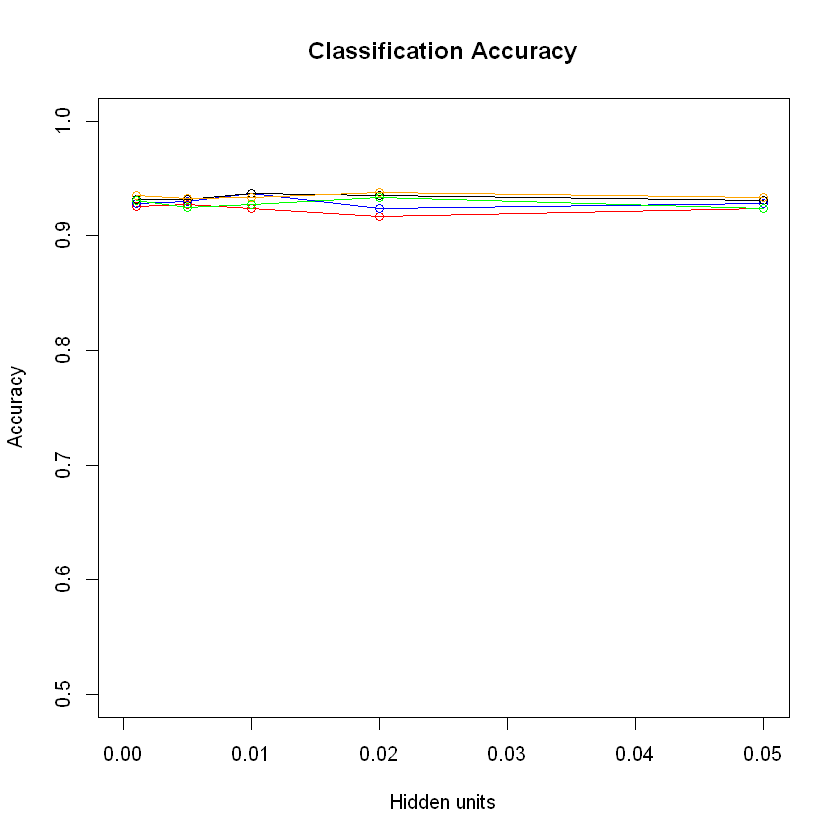

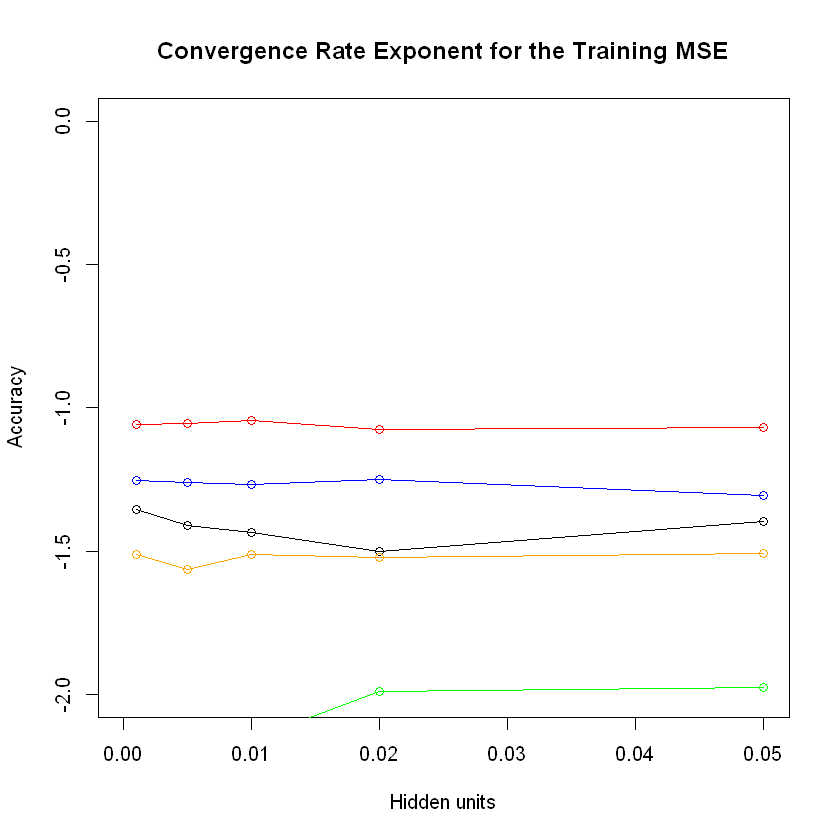

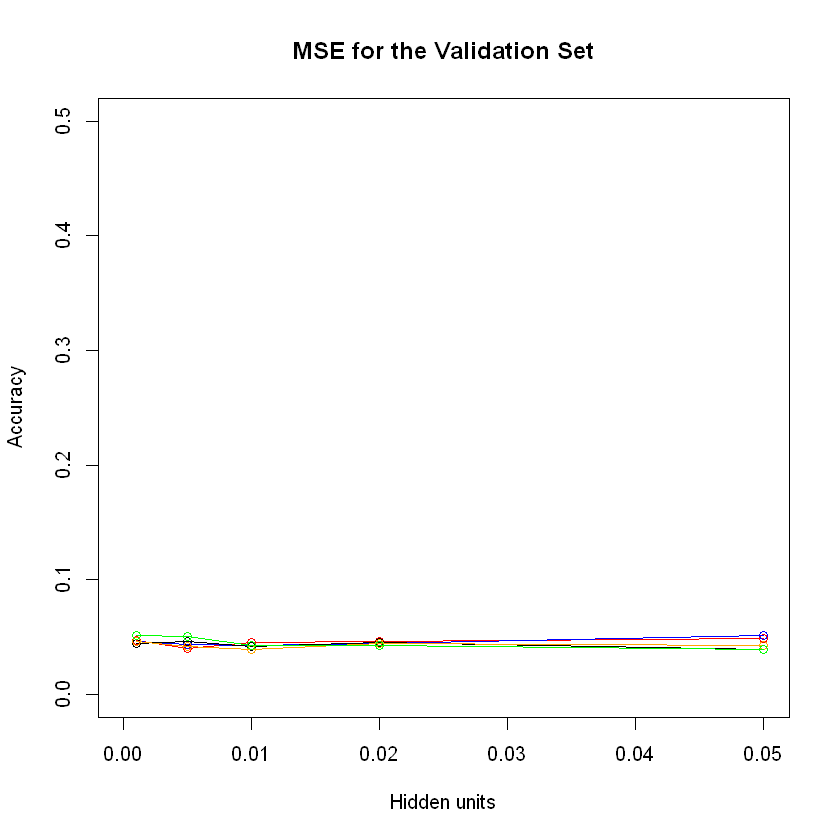

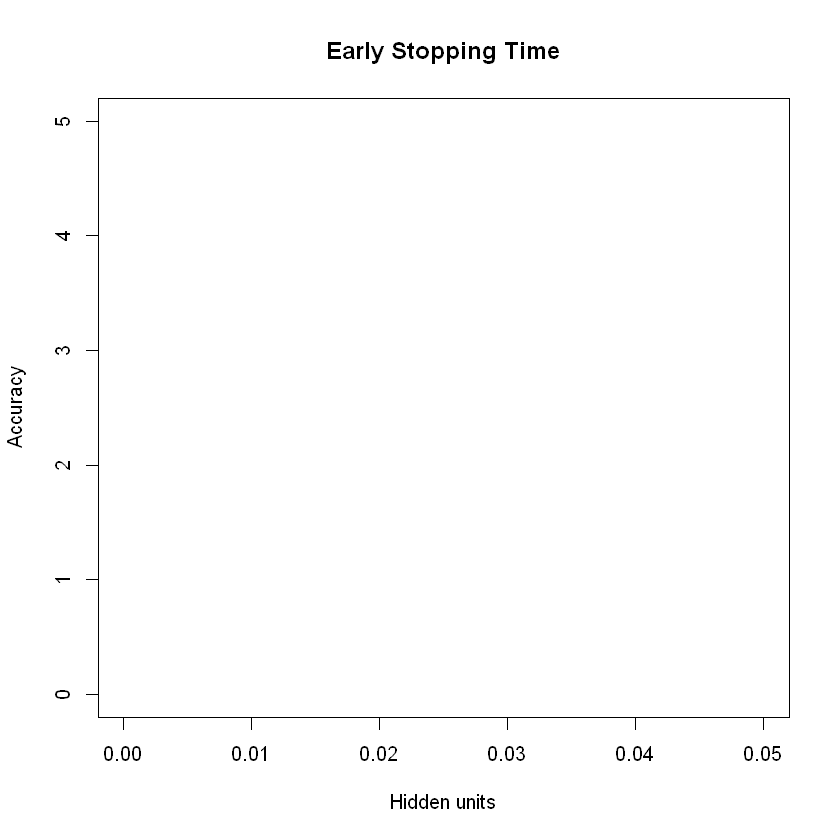

In [5]:
#Find appropriate learning rate and momentum rate for given number of hidden units for Tanh and cross-entropy
library(h2o)
localH2O<- h2o.init()

#this function does not actually exist
#h2o.addFunction(localH2O, function(x) { 1/(1+exp(-x)) }, "Logsig")

#Import the data from the website repository, first name the path
train_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra"
test_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes"

#give path to the importFile command in R
train1 <- h2o.importFile(train_file)
test <- h2o.importFile(test_file)

#get summary of data
#summary(train)
#summary(test)

#get a vector of the number of instances and the length of the feature vectors
dtrain <- dim(train1)
dtest <- dim(test)

#split training data at random for a selection to train on and a selection to validate hyperparameters
splits <- h2o.splitFrame(train1, c(0.8), seed=1385)
train <- h2o.assign(splits[[1]], "train.hex")
valid <- h2o.assign(splits[[2]], "valid.hex")

#can do some initial data inspection using, C65 is the labeled category
#par(mfrow=c(1,1))
#plot(h2o.tabulate(train, "C40", "C65"))
#plot(h2o.tabulate(train, "C30", "C65"))


#treat vectors as integer categories(factors), and thus not factors
train <- as.factor(train)
valid <- as.factor(valid)
test <- as.factor(test)

#set the target and feature(predictor) vectors
response <- "C65"
predictors <- setdiff(names(train1), response)
predictors

#set parameters for the hidden layers search, with low learning rate, e.g. the 0.01
#set number of  momentum rates to look at
momrates <- c(0.0, 0.05, 0.1, 0.5, 0.9)
#set number of rates to look at
rates <- c(0.001,0.005,0.01,0.02,0.05)

#give a string index for all of these lists
#choose hidden layers, by looping over a set of them
#extract convergence rate and accuracy
#do study on learning rate for both tanh, and Rectifier for the hyperparameters

#give initial lists
explist <- list()
accuracylist <- list()
vmselist <- list()
trmselist <- list()
stoplist <- list()

count=1

for (i in 1:length(momrates)){
    for (j in 1:length(rates)){
        #automatically uses softmax output
        m1 <- h2o.deeplearning(
            model_id="dl_model_first", 
            training_frame=train, 
            validation_frame=valid,   ## validation dataset: used for scoring and early stopping
            x=predictors,
            y=response,
            #hidden=c(200,200),       ## default: 2 hidden layers with 200 neurons each
            epochs=500,#000,                ##  controls stopping times
            #variable_importances=T,    ## not enabled by default
            distribution = "multinomial", ##  we have categorical data
            standardize = T,  ## standardize the input data
            activation = "Tanh",  ## may choose Tanh or Rectifier, i.e. ReLU. Logistic sigmoid not included
            categorical_encoding="OneHotInternal",  ## this ensures the use of the 1 of c encoding with "OneHotInternal"
            loss = "CrossEntropy",  ## can be "Quadratic" or "CrossEntropy"
            adaptive_rate = F, ##turn adaptive rate adjustments off
            rate = rates[i], #the learning rate, start around 0.5, should be positive
            #to reduce number of hyper parameters we will do this so that 
            momentum_start = momrates[j], #the momentum at the start, overall must be 0<\alpha<1
            momentum_ramp = 1, #the number of samples overwhich the ramp occurs
            momentum_stable = momrates[j], #the stable momentum, should be again less than 1 and greater than 0
            #train_samples_per_iteration = 0, #number of training samples per mapreduce iteraton, 
            #special vals 0 one epoch, -1 all available data, -2 autotuning
            #want to disable early stopping
            classification_stop = -1,
            regression_stop = -1,
            overwrite_with_best_model=FALSE,  #don't save the best model
            #change to best hidden list
            hidden=c(50,50)#unlist(hiddenlist[count])#c(50,50) ## hidden layers c(100,100) 2 hidden layers with 100 neurons each
        )
        
        #find the convergence statistics for the 
        #find performance statistics i.e. accuracy for the training set
        #m2 = h2o.performance(m1, newdata=test, train=FALSE, valid=FALSE, xval=FALSE)
        Mat = h2o.confusionMatrix(m1, newdata=test, valid=FALSE)
        #accuracy on the training case
        accuracy = 1-tail(Mat$Error, n=1)
        
        #final mean squared error for the training and validation sets
        vmse <- h2o.mse(m1, valid=TRUE, train=FALSE)
        trmse <- h2o.mse(m1, valid=FALSE, train=TRUE)

        #now fit the convergence with a power law
        tr <- m1@model$scoring_history$training_rmse
        v <- m1@model$scoring_history$validation_rmse
        ep <- m1@model$scoring_history$epochs

        fit <- lm(log(ep)~log(tr))
        pow <- summary(fit)$coefficients[2,1]
        exp <- 1/pow
        
        #put everything in a list
        explist[[length(explist)+1]] <- exp
        accuracylist[[length(accuracylist)+1]] <- accuracy
        vmselist[[length(vmselist)+1]] <- vmse
        trmselist[[length(trmselist)+1]] <- trmse
        stoplist[[length(stoplist)+1]]  <- tail(ep, n=1)
        count
        count <- count+1
        }}

png(file = "ClassAcc_vRate_ClassAcc_CrossEnt.jpg")
#plot the accuracy of everything
acc <- unlist(accuracylist)
Macc <- matrix(acc, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0.9,1.0), xlim=c(0,0.05), xlab = "Learning rate", ylab="Accuracy", main ="Classification Accuracy")
lines(rates, Macc[1,1:length(rates)], type = "o", col = "red")
lines(rates, Macc[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Macc[3,1:length(rates)], type = "o", col = "black")
lines(rates, Macc[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Macc[5,1:length(rates)], type = "o", col = "green")
legend(0.03, 1, c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off() 

png(file = "ClassAcc_vRate_exp_CrossEnt.jpg")
#plot the convergence rate of it all
expon <- unlist(explist)
Mexp <- matrix(expon, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(-3,0), xlim=c(0,0.05), xlab = "Learning rate", ylab="Exponent", main ="Convergence Rate Exponent for the Training MSE")
lines(rates, Mexp[1,1:length(rates)], type = "o", col = "red")
lines(rates, Mexp[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Mexp[3,1:length(rates)], type = "o", col = "black")
lines(rates, Mexp[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Mexp[5,1:length(rates)], type = "o", col = "green")
legend(.03, 0, c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off() 

png(file = "ClassAcc_vRate_MSE_CrossEnt.jpg")
#plot the MSE for the validation case at the last iteration
vmse2 <- unlist(vmselist)
Mvmse <- matrix(vmse2, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0,0.1), xlim=c(0,0.05), xlab = "Learning rate", ylab="MSE", main ="MSE for the Validation Set")
lines(rates, Mvmse[1,1:length(rates)], type = "o", col = "red")
lines(rates, Mvmse[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Mvmse[3,1:length(rates)], type = "o", col = "black")
lines(rates, Mvmse[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Mvmse[5,1:length(rates)], type = "o", col = "green")
legend(0.03, 0.1, c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()         

png(file = "ClassAcc_vRate_stop_CrossEnt.jpg")
#plot the MSE for the validation case at the last iteration
stop <- unlist(stoplist)
Mstop <- matrix(stop, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0,150), xlim=c(0,0.05), xlab = "Learning rate", ylab="Stopping Time", main ="Early Stopping Time")
lines(rates, Mstop[1,1:length(rates)], type = "o", col = "red")
lines(rates, Mstop[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Mstop[3,1:length(rates)], type = "o", col = "black")
lines(rates, Mstop[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Mstop[5,1:length(rates)], type = "o", col = "green")
legend(0.03, 50,c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()         


 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 hours 8 minutes 
    H2O cluster version:        3.10.3.6 
    H2O cluster version age:    10 days  
    H2O cluster name:           H2O_started_from_R_ejmurphy_ozt674 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.67 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.2 (2016-10-31) 

  |======================================================================| 100%
  |======================================================================| 100%


[1] "C1"  "C2"  "C3"  "C4"  "C5"  "C6"  "C7"  "C8"  "C9"  "C10" "C11" "C12"
[13] "C13" "C14" "C15" "C16" "C17" "C18" "C19" "C20" "C21" "C22" "C23" "C24"
[25] "C25" "C26" "C27" "C28" "C29" "C30" "C31" "C32" "C33" "C34" "C35" "C36"
[37] "C37" "C38" "C39" "C40" "C41" "C42" "C43" "C44" "C45" "C46" "C47" "C48"
[49] "C49" "C50" "C51" "C52" "C53" "C54" "C55" "C56" "C57" "C58" "C59" "C60"
[61] "C61" "C62" "C63" "C64"

Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


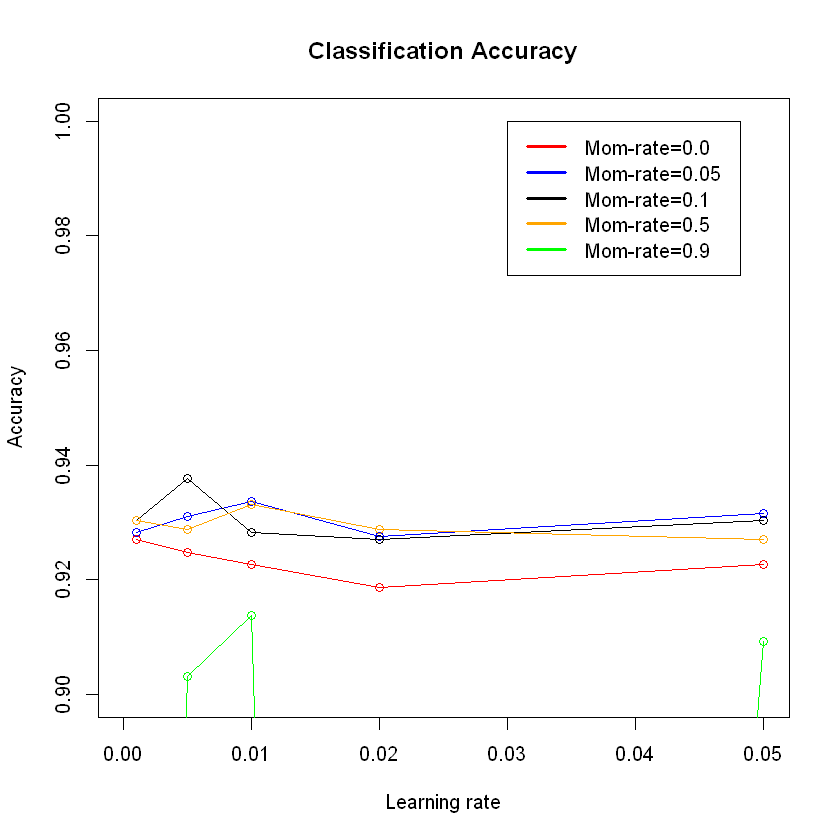

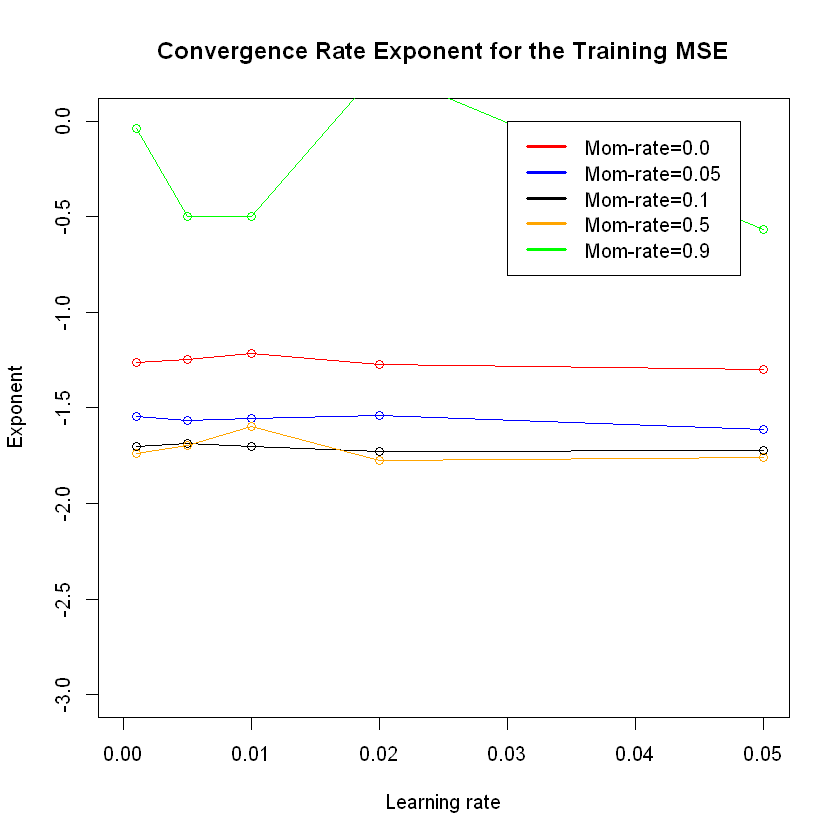

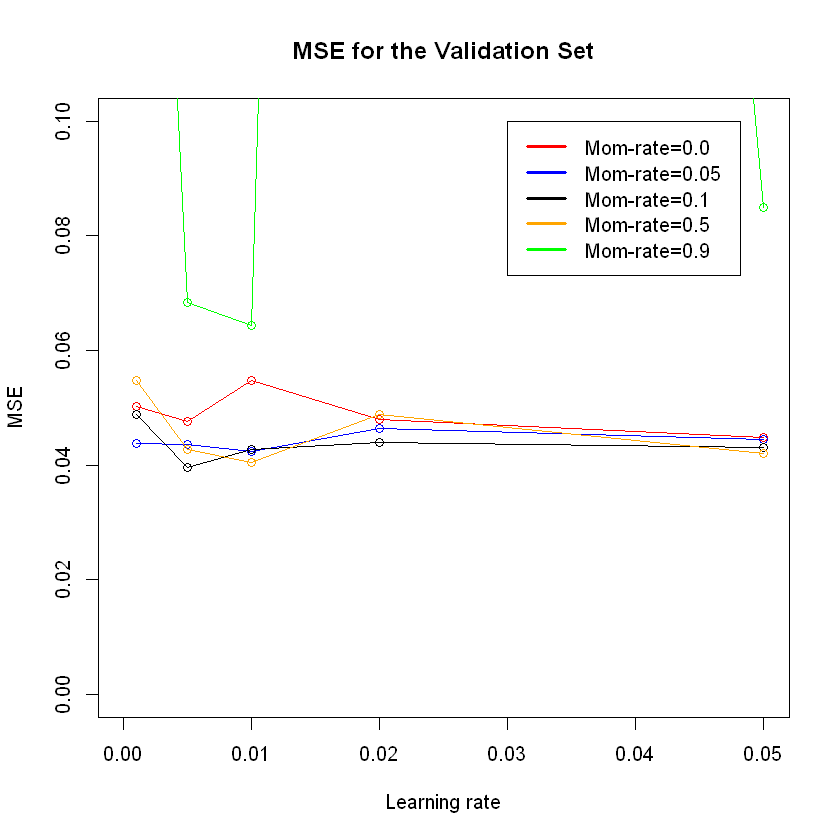

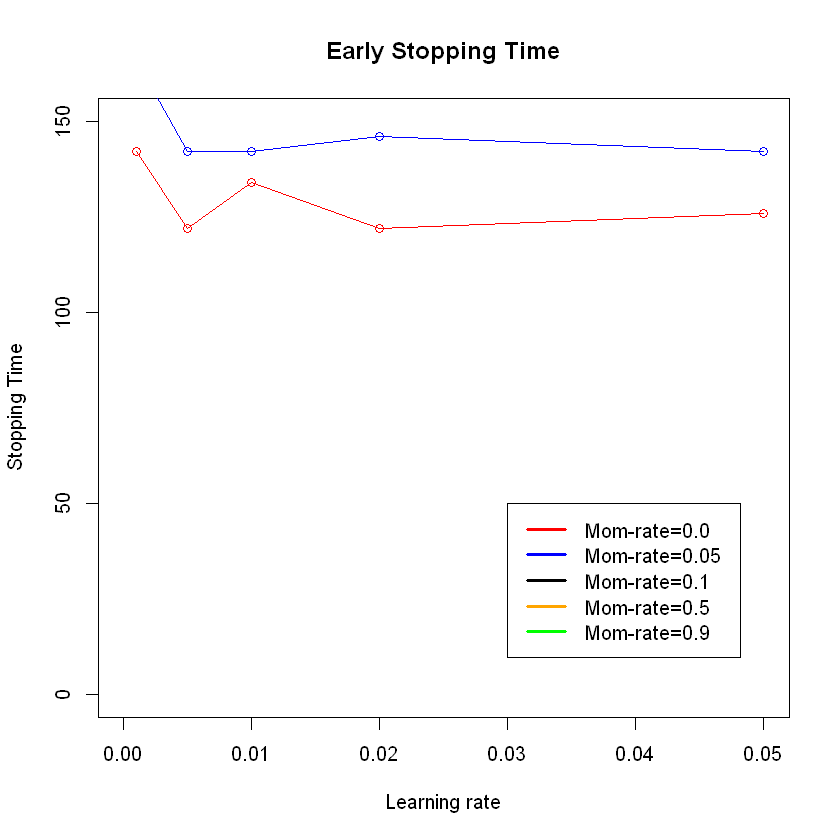

In [28]:
#Find appropriate learning rate and momentum rate for given number of hidden units for the ReLU term
library(h2o)
localH2O<- h2o.init()

#this function does not actually exist
#h2o.addFunction(localH2O, function(x) { 1/(1+exp(-x)) }, "Logsig")

#Import the data from the website repository, first name the path
train_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra"
test_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes"

#give path to the importFile command in R
train1 <- h2o.importFile(train_file)
test <- h2o.importFile(test_file)

#get summary of data
#summary(train)
#summary(test)

#get a vector of the number of instances and the length of the feature vectors
dtrain <- dim(train1)
dtest <- dim(test)

#split training data at random for a selection to train on and a selection to validate hyperparameters
splits <- h2o.splitFrame(train1, c(0.8), seed=1385)
train <- h2o.assign(splits[[1]], "train.hex")
valid <- h2o.assign(splits[[2]], "valid.hex")

#can do some initial data inspection using, C65 is the labeled category
#par(mfrow=c(1,1))
#plot(h2o.tabulate(train, "C40", "C65"))
#plot(h2o.tabulate(train, "C30", "C65"))


#treat vectors as integer categories(factors), and thus not factors
train <- as.factor(train)
valid <- as.factor(valid)
test <- as.factor(test)

#set the target and feature(predictor) vectors
response <- "C65"
predictors <- setdiff(names(train1), response)
predictors

#set parameters for the hidden layers search, with low learning rate, e.g. the 0.01
#set number of  momentum rates to look at
momrates <- c(0.0, 0.05, 0.1, 0.5, 0.9)
#set number of rates to look at
rates <- c(0.001,0.005,0.01,0.02,0.05)

#give a string index for all of these lists
#choose hidden layers, by looping over a set of them
#extract convergence rate and accuracy
#do study on learning rate for both tanh, and Rectifier for the hyperparameters

#give initial lists
explist <- list()
accuracylist <- list()
vmselist <- list()
trmselist <- list()
stoplist <- list()

count=1

for (i in 1:length(momrates)){
    for (j in 1:length(rates)){
        #automatically uses softmax output
        m1 <- h2o.deeplearning(
            model_id="dl_model_first", 
            training_frame=train, 
            validation_frame=valid,   ## validation dataset: used for scoring and early stopping
            x=predictors,
            y=response,
            #hidden=c(200,200),       ## default: 2 hidden layers with 200 neurons each
            epochs=500,#000,                ##  controls stopping times
            #variable_importances=T,    ## not enabled by default
            distribution = "multinomial", ##  we have categorical data
            standardize = T,  ## standardize the input data
            activation = "Rectifier",  ## may choose Tanh or Rectifier, i.e. ReLU. Logistic sigmoid not included
            categorical_encoding="OneHotInternal",  ## this ensures the use of the 1 of c encoding with "OneHotInternal"
            loss = "CrossEntropy",  ## can be "Quadratic" or "CrossEntropy"
            adaptive_rate = F, ##turn adaptive rate adjustments off
            rate = rates[i], #the learning rate, start around 0.5, should be positive
            #to reduce number of hyper parameters we will do this so that 
            momentum_start = momrates[j], #the momentum at the start, overall must be 0<\alpha<1
            momentum_ramp = 1, #the number of samples overwhich the ramp occurs
            momentum_stable = momrates[j], #the stable momentum, should be again less than 1 and greater than 0
            #train_samples_per_iteration = 0, #number of training samples per mapreduce iteraton, 
            #special vals 0 one epoch, -1 all available data, -2 autotuning
            #want to disable early stopping
            classification_stop = -1,
            regression_stop = -1,
            overwrite_with_best_model=FALSE,  #don't save the best model
            #change to best hidden list
            hidden=c(50,50)#unlist(hiddenlist[count])#c(50,50) ## hidden layers c(100,100) 2 hidden layers with 100 neurons each
        )
        
        #find the convergence statistics for the 
        #find performance statistics i.e. accuracy for the training set
        #m2 = h2o.performance(m1, newdata=test, train=FALSE, valid=FALSE, xval=FALSE)
        Mat = h2o.confusionMatrix(m1, newdata=test, valid=FALSE)
        #accuracy on the training case
        accuracy = 1-tail(Mat$Error, n=1)
        
        #final mean squared error for the training and validation sets
        vmse <- h2o.mse(m1, valid=TRUE, train=FALSE)
        trmse <- h2o.mse(m1, valid=FALSE, train=TRUE)

        #now fit the convergence with a power law
        tr <- m1@model$scoring_history$training_rmse
        v <- m1@model$scoring_history$validation_rmse
        ep <- m1@model$scoring_history$epochs

        fit <- lm(log(ep)~log(tr))
        pow <- summary(fit)$coefficients[2,1]
        exp <- 1/pow
        
        #put everything in a list
        explist[[length(explist)+1]] <- exp
        accuracylist[[length(accuracylist)+1]] <- accuracy
        vmselist[[length(vmselist)+1]] <- vmse
        trmselist[[length(trmselist)+1]] <- trmse
        stoplist[[length(stoplist)+1]]  <- tail(ep, n=1)
        count
        count <- count+1
        }}

png(file = "ClassAcc_vRate_ClassAcc_CrossEnt_RELU.jpg")
#plot the accuracy of everything
acc <- unlist(accuracylist)
Macc <- matrix(acc, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0.8,1.0), xlim=c(0,0.05), xlab = "Learning rate", ylab="Accuracy", main ="Classification Accuracy")
lines(rates, Macc[1,1:length(rates)], type = "o", col = "red")
lines(rates, Macc[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Macc[3,1:length(rates)], type = "o", col = "black")
lines(rates, Macc[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Macc[5,1:length(rates)], type = "o", col = "green")
legend(0.03, 1, c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off() 

png(file = "ClassAcc_vRate_exp_CrossEnt_RELU.jpg")
#plot the convergence rate of it all
expon <- unlist(explist)
Mexp <- matrix(expon, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(-3,0), xlim=c(0,0.05), xlab = "Learning rate", ylab="Exponent", main ="Convergence Rate Exponent for the Training MSE")
lines(rates, Mexp[1,1:length(rates)], type = "o", col = "red")
lines(rates, Mexp[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Mexp[3,1:length(rates)], type = "o", col = "black")
lines(rates, Mexp[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Mexp[5,1:length(rates)], type = "o", col = "green")
legend(.03, 0, c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off() 

png(file = "ClassAcc_vRate_MSE_CrossEnt_RELU.jpg")
#plot the MSE for the validation case at the last iteration
vmse2 <- unlist(vmselist)
Mvmse <- matrix(vmse2, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0,0.1), xlim=c(0,0.05), xlab = "Learning rate", ylab="MSE", main ="MSE for the Validation Set")
lines(rates, Mvmse[1,1:length(rates)], type = "o", col = "red")
lines(rates, Mvmse[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Mvmse[3,1:length(rates)], type = "o", col = "black")
lines(rates, Mvmse[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Mvmse[5,1:length(rates)], type = "o", col = "green")
legend(0.03, 0.1, c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()         

png(file = "ClassAcc_vRate_stop_CrossEnt_RELU.jpg")
#plot the MSE for the validation case at the last iteration
stop <- unlist(stoplist)
Mstop <- matrix(stop, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0,300), xlim=c(0,0.05), xlab = "Learning rate", ylab="Stopping Time", main ="Early Stopping Time")
lines(rates, Mstop[1,1:length(rates)], type = "o", col = "red")
lines(rates, Mstop[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Mstop[3,1:length(rates)], type = "o", col = "black")
lines(rates, Mstop[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Mstop[5,1:length(rates)], type = "o", col = "green")
legend(0.03, 100,c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()  

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 hours 38 minutes 
    H2O cluster version:        3.10.3.6 
    H2O cluster version age:    10 days  
    H2O cluster name:           H2O_started_from_R_ejmurphy_ozt674 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.63 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.2 (2016-10-31) 

  |======================================================================| 100%
  |======================================================================| 100%


[1] "C1"  "C2"  "C3"  "C4"  "C5"  "C6"  "C7"  "C8"  "C9"  "C10" "C11" "C12"
[13] "C13" "C14" "C15" "C16" "C17" "C18" "C19" "C20" "C21" "C22" "C23" "C24"
[25] "C25" "C26" "C27" "C28" "C29" "C30" "C31" "C32" "C33" "C34" "C35" "C36"
[37] "C37" "C38" "C39" "C40" "C41" "C42" "C43" "C44" "C45" "C46" "C47" "C48"
[49] "C49" "C50" "C51" "C52" "C53" "C54" "C55" "C56" "C57" "C58" "C59" "C60"
[61] "C61" "C62" "C63" "C64"

Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


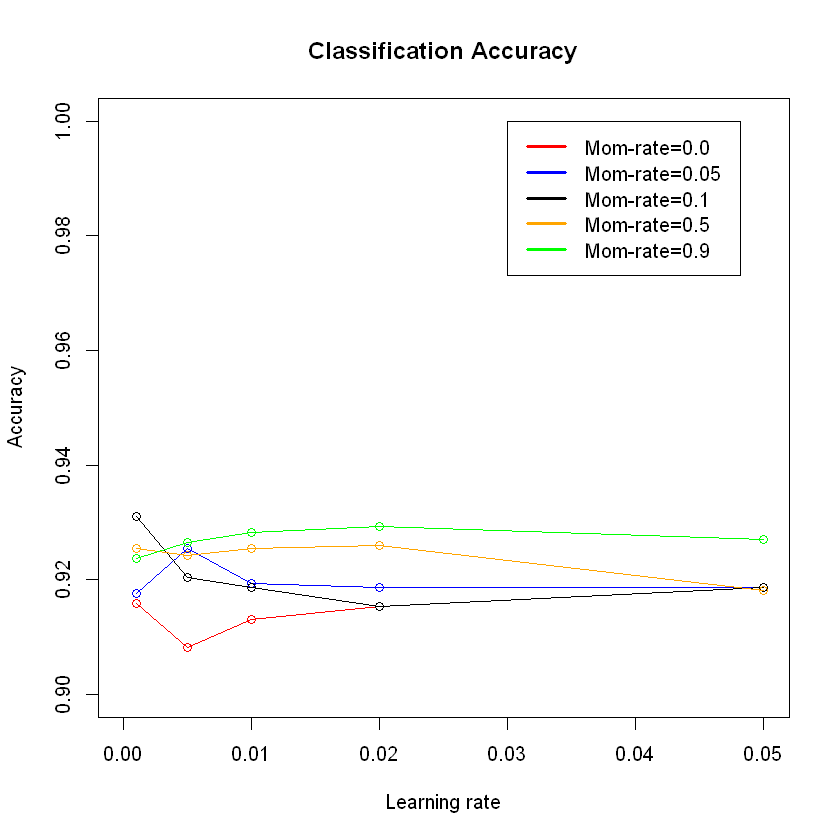

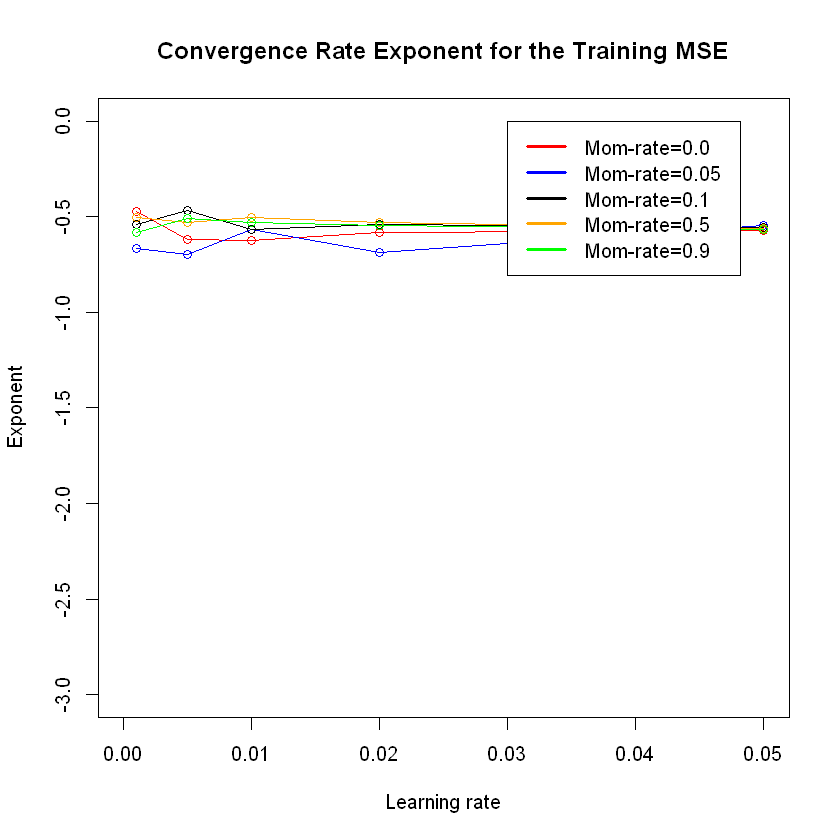

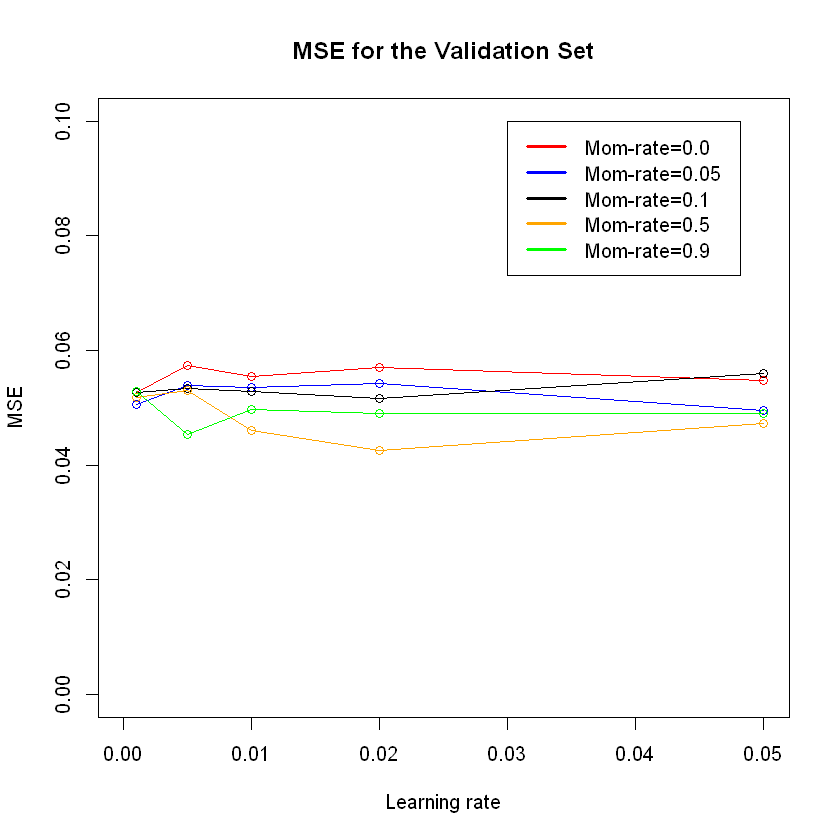

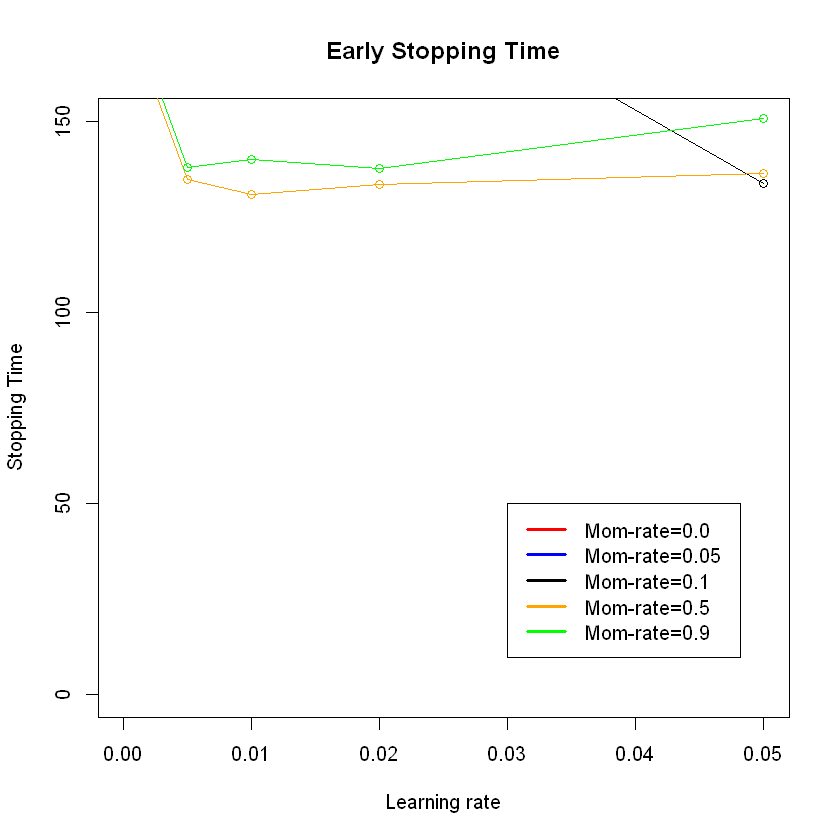

In [35]:
#Find appropriate learning rate and momentum rate for given number of hidden units for Tanh and quadratic loss function
library(h2o)
localH2O<- h2o.init()

#this function does not actually exist
#h2o.addFunction(localH2O, function(x) { 1/(1+exp(-x)) }, "Logsig")

#Import the data from the website repository, first name the path
train_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra"
test_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes"

#give path to the importFile command in R
train1 <- h2o.importFile(train_file)
test <- h2o.importFile(test_file)

#get summary of data
#summary(train)
#summary(test)

#get a vector of the number of instances and the length of the feature vectors
dtrain <- dim(train1)
dtest <- dim(test)

#split training data at random for a selection to train on and a selection to validate hyperparameters
splits <- h2o.splitFrame(train1, c(0.8), seed=1385)
train <- h2o.assign(splits[[1]], "train.hex")
valid <- h2o.assign(splits[[2]], "valid.hex")

#can do some initial data inspection using, C65 is the labeled category
#par(mfrow=c(1,1))
#plot(h2o.tabulate(train, "C40", "C65"))
#plot(h2o.tabulate(train, "C30", "C65"))


#treat vectors as integer categories(factors), and thus not factors
train <- as.factor(train)
valid <- as.factor(valid)
test <- as.factor(test)

#set the target and feature(predictor) vectors
response <- "C65"
predictors <- setdiff(names(train1), response)
predictors

#set parameters for the hidden layers search, with low learning rate, e.g. the 0.01
#set number of  momentum rates to look at
momrates <- c(0.0, 0.05, 0.1, 0.5, 0.9)
#set number of rates to look at
rates <- c(0.001,0.005,0.01,0.02,0.05)

#give a string index for all of these lists
#choose hidden layers, by looping over a set of them
#extract convergence rate and accuracy
#do study on learning rate for both tanh, and Rectifier for the hyperparameters

#give initial lists
explist <- list()
accuracylist <- list()
vmselist <- list()
trmselist <- list()
stoplist <- list()

count=1

for (i in 1:length(momrates)){
    for (j in 1:length(rates)){
        #automatically uses softmax output
        m1 <- h2o.deeplearning(
            model_id="dl_model_first", 
            training_frame=train, 
            validation_frame=valid,   ## validation dataset: used for scoring and early stopping
            x=predictors,
            y=response,
            #hidden=c(200,200),       ## default: 2 hidden layers with 200 neurons each
            epochs=500,                ##  controls stopping times
            #variable_importances=T,    ## not enabled by default
            distribution = "multinomial", ##  we have categorical data
            standardize = T,  ## standardize the input data
            activation = "Tanh",  ## may choose Tanh or Rectifier, i.e. ReLU. Logistic sigmoid not included
            categorical_encoding="OneHotInternal",  ## this ensures the use of the 1 of c encoding with "OneHotInternal"
            loss = "Quadratic",  ## can be "Quadratic" or "CrossEntropy"
            adaptive_rate = F, ##turn adaptive rate adjustments off
            rate = rates[i], #the learning rate, start around 0.5, should be positive
            #to reduce number of hyper parameters we will do this so that 
            momentum_start = momrates[j], #the momentum at the start, overall must be 0<\alpha<1
            momentum_ramp = 1, #the number of samples overwhich the ramp occurs
            momentum_stable = momrates[j], #the stable momentum, should be again less than 1 and greater than 0
            #train_samples_per_iteration = 0, #number of training samples per mapreduce iteraton, 
            #special vals 0 one epoch, -1 all available data, -2 autotuning
            #want to disable early stopping
            classification_stop = -1,
            regression_stop = -1,
            overwrite_with_best_model=FALSE,  #don't save the best model
            #change to best hidden list
            hidden=c(40,40)#unlist(hiddenlist[count])#c(50,50) ## hidden layers c(100,100) 2 hidden layers with 100 neurons each
        )
        
        #find the convergence statistics for the 
        #find performance statistics i.e. accuracy for the training set
        #m2 = h2o.performance(m1, newdata=test, train=FALSE, valid=FALSE, xval=FALSE)
        Mat = h2o.confusionMatrix(m1, newdata=test, valid=FALSE)
        #accuracy on the training case
        accuracy = 1-tail(Mat$Error, n=1)
        
        #final mean squared error for the training and validation sets
        vmse <- h2o.mse(m1, valid=TRUE, train=FALSE)
        trmse <- h2o.mse(m1, valid=FALSE, train=TRUE)

        #now fit the convergence with a power law
        tr <- m1@model$scoring_history$training_rmse
        v <- m1@model$scoring_history$validation_rmse
        ep <- m1@model$scoring_history$epochs

        fit <- lm(log(ep)~log(tr))
        pow <- summary(fit)$coefficients[2,1]
        exp <- 1/pow
        
        #put everything in a list
        explist[[length(explist)+1]] <- exp
        accuracylist[[length(accuracylist)+1]] <- accuracy
        vmselist[[length(vmselist)+1]] <- vmse
        trmselist[[length(trmselist)+1]] <- trmse
        stoplist[[length(stoplist)+1]]  <- tail(ep, n=1)
        count
        count <- count+1
        }}


png(file = "ClassAcc_vRate_ClassAcc_Quad.jpg")
#plot the accuracy of everything
acc <- unlist(accuracylist)
Macc <- matrix(acc, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0.9,1.0), xlim=c(0,0.05), xlab = "Learning rate", ylab="Accuracy", main ="Classification Accuracy")
lines(rates, Macc[1,1:length(rates)], type = "o", col = "red")
lines(rates, Macc[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Macc[3,1:length(rates)], type = "o", col = "black")
lines(rates, Macc[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Macc[5,1:length(rates)], type = "o", col = "green")
legend(0.03, 1, c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off() 

png(file = "ClassAcc_vRate_exp_Quad.jpg")
#plot the convergence rate of it all
expon <- unlist(explist)
Mexp <- matrix(expon, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(-1,0), xlim=c(0,0.05), xlab = "Learning rate", ylab="Exponent", main ="Convergence Rate Exponent for the Training MSE")
lines(rates, Mexp[1,1:length(rates)], type = "o", col = "red")
lines(rates, Mexp[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Mexp[3,1:length(rates)], type = "o", col = "black")
lines(rates, Mexp[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Mexp[5,1:length(rates)], type = "o", col = "green")
legend(.03, 0, c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off() 

png(file = "ClassAcc_vRate_MSE_Quad.jpg")
#plot the MSE for the validation case at the last iteration
vmse2 <- unlist(vmselist)
Mvmse <- matrix(vmse2, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0,0.1), xlim=c(0,0.05), xlab = "Learning rate", ylab="MSE", main ="MSE for the Validation Set")
lines(rates, Mvmse[1,1:length(rates)], type = "o", col = "red")
lines(rates, Mvmse[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Mvmse[3,1:length(rates)], type = "o", col = "black")
lines(rates, Mvmse[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Mvmse[5,1:length(rates)], type = "o", col = "green")
legend(0.03, 0.1, c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()         

png(file = "ClassAcc_vRate_stop_Quad.jpg")
#plot the MSE for the validation case at the last iteration
stop <- unlist(stoplist)
Mstop <- matrix(stop, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0,500), xlim=c(0,0.05), xlab = "Learning rate", ylab="Stopping Time", main ="Early Stopping Time")
lines(rates, Mstop[1,1:length(rates)], type = "o", col = "red")
lines(rates, Mstop[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Mstop[3,1:length(rates)], type = "o", col = "black")
lines(rates, Mstop[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Mstop[5,1:length(rates)], type = "o", col = "green")
legend(0.03, 50,c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()   

In [4]:
testlist <- list(c(2,20), c(30,45,60), c(91,87))
testlist[2]

[[1]]
[1] 30 45 60

In [38]:
png(file = "ClassAcc_vRate_ClassAcc_Quad.jpg")
#plot the accuracy of everything
acc <- unlist(accuracylist)
Macc <- matrix(acc, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0.9,1.0), xlim=c(0,0.05), xlab = "Learning rate", ylab="Accuracy", main ="Classification Accuracy")
lines(rates, Macc[1,1:length(rates)], type = "o", col = "red")
lines(rates, Macc[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Macc[3,1:length(rates)], type = "o", col = "black")
lines(rates, Macc[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Macc[5,1:length(rates)], type = "o", col = "green")
legend(0.03, 1, c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off() 

png(file = "ClassAcc_vRate_exp_Quad.jpg")
#plot the convergence rate of it all
expon <- unlist(explist)
Mexp <- matrix(expon, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(-1,0), xlim=c(0,0.05), xlab = "Learning rate", ylab="Exponent", main ="Convergence Rate Exponent for the Training MSE")
lines(rates, Mexp[1,1:length(rates)], type = "o", col = "red")
lines(rates, Mexp[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Mexp[3,1:length(rates)], type = "o", col = "black")
lines(rates, Mexp[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Mexp[5,1:length(rates)], type = "o", col = "green")
legend(.03, 0, c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off() 

png(file = "ClassAcc_vRate_MSE_Quad.jpg")
#plot the MSE for the validation case at the last iteration
vmse2 <- unlist(vmselist)
Mvmse <- matrix(vmse2, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0,0.1), xlim=c(0,0.05), xlab = "Learning rate", ylab="MSE", main ="MSE for the Validation Set")
lines(rates, Mvmse[1,1:length(rates)], type = "o", col = "red")
lines(rates, Mvmse[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Mvmse[3,1:length(rates)], type = "o", col = "black")
lines(rates, Mvmse[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Mvmse[5,1:length(rates)], type = "o", col = "green")
legend(0.03, 0.1, c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()         

png(file = "ClassAcc_vRate_stop_Quad.jpg")
#plot the MSE for the validation case at the last iteration
stop <- unlist(stoplist)
Mstop <- matrix(stop, nrow=length(momrates), ncol=length(rates), byrow = TRUE)
#set up the plot
plot(x=NULL,y=NULL, ylim=c(0,500), xlim=c(0,0.05), xlab = "Learning rate", ylab="Stopping Time", main ="Early Stopping Time")
lines(rates, Mstop[1,1:length(rates)], type = "o", col = "red")
lines(rates, Mstop[2,1:length(rates)], type = "o", col = "blue")
lines(rates, Mstop[3,1:length(rates)], type = "o", col = "black")
lines(rates, Mstop[4,1:length(rates)], type = "o", col = "orange")
lines(rates, Mstop[5,1:length(rates)], type = "o", col = "green")
legend(0.03, 50,c("Mom-rate=0.0", "Mom-rate=0.05","Mom-rate=0.1","Mom-rate=0.5","Mom-rate=0.9"),lwd=c(2.5,2.5),col=c("red","blue","black","orange","green"))
dev.off()     

png 
  2

png 
  2

png 
  2

png 
  2

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         48 minutes 30 seconds 
    H2O cluster version:        3.10.3.6 
    H2O cluster version age:    10 days  
    H2O cluster name:           H2O_started_from_R_ejmurphy_ozt674 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.68 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.2 (2016-10-31) 

  |======================================================================| 100%
  |======================================================================| 100%


[1] "C1"  "C2"  "C3"  "C4"  "C5"  "C6"  "C7"  "C8"  "C9"  "C10" "C11" "C12"
[13] "C13" "C14" "C15" "C16" "C17" "C18" "C19" "C20" "C21" "C22" "C23" "C24"
[25] "C25" "C26" "C27" "C28" "C29" "C30" "C31" "C32" "C33" "C34" "C35" "C36"
[37] "C37" "C38" "C39" "C40" "C41" "C42" "C43" "C44" "C45" "C46" "C47" "C48"
[49] "C49" "C50" "C51" "C52" "C53" "C54" "C55" "C56" "C57" "C58" "C59" "C60"
[61] "C61" "C62" "C63" "C64"

Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


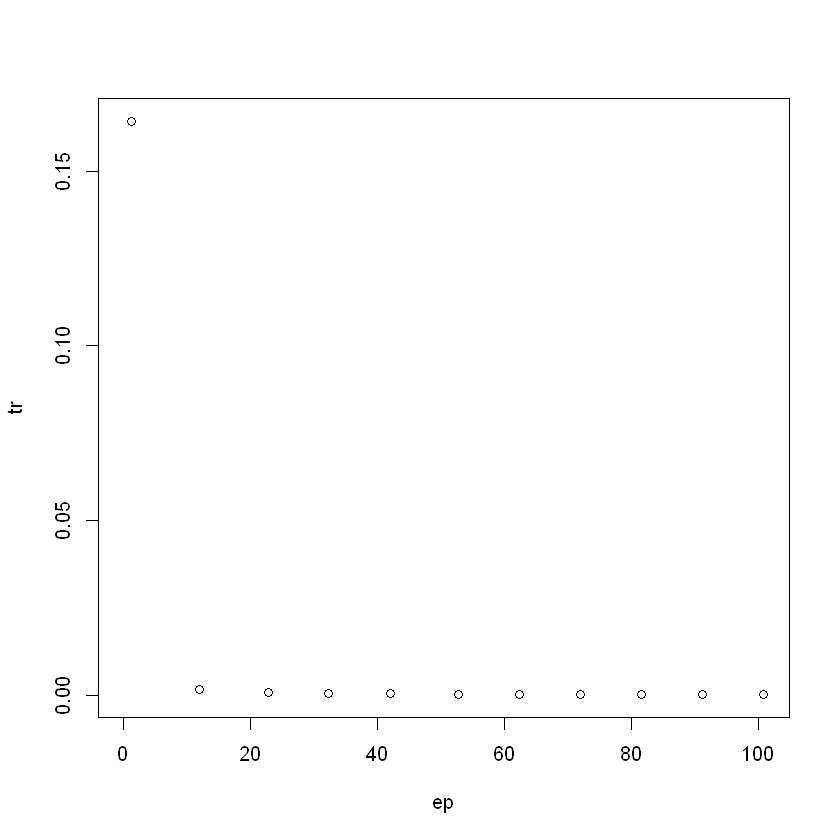

In [11]:
#this piece is for plotting how I report the convergence speed, from tanh, cross-entropy and chosen final accuracies 

#Find appropriate learning rate and momentum rate for given number of hidden units for Tanh and cross-entropy
library(h2o)
localH2O<- h2o.init()

#this function does not actually exist
#h2o.addFunction(localH2O, function(x) { 1/(1+exp(-x)) }, "Logsig")

#Import the data from the website repository, first name the path
train_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra"
test_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes"

#give path to the importFile command in R
train1 <- h2o.importFile(train_file)
test <- h2o.importFile(test_file)

#get summary of data
#summary(train)
#summary(test)

#get a vector of the number of instances and the length of the feature vectors
dtrain <- dim(train1)
dtest <- dim(test)

#split training data at random for a selection to train on and a selection to validate hyperparameters
splits <- h2o.splitFrame(train1, c(0.8), seed=1385)
train <- h2o.assign(splits[[1]], "train.hex")
valid <- h2o.assign(splits[[2]], "valid.hex")

#can do some initial data inspection using, C65 is the labeled category
#par(mfrow=c(1,1))
#plot(h2o.tabulate(train, "C40", "C65"))
#plot(h2o.tabulate(train, "C30", "C65"))


#treat vectors as integer categories(factors), and thus not factors
train <- as.factor(train)
valid <- as.factor(valid)
test <- as.factor(test)

#set the target and feature(predictor) vectors
response <- "C65"
predictors <- setdiff(names(train1), response)
predictors

#set parameters for the hidden layers search, with low learning rate, e.g. the 0.01
#set number of  momentum rates to look at
#momrates <- c(0.0, 0.05, 0.1, 0.5, 0.9)
#set number of rates to look at
#rates <- c(0.001,0.005,0.01,0.02,0.05)

#give a string index for all of these lists
#choose hidden layers, by looping over a set of them
#extract convergence rate and accuracy
#do study on learning rate for both tanh, and Rectifier for the hyperparameters

 m1 <- h2o.deeplearning(
            model_id="dl_model_first", 
            training_frame=train, 
            validation_frame=valid,   ## validation dataset: used for scoring and early stopping
            x=predictors,
            y=response,
            #hidden=c(200,200),       ## default: 2 hidden layers with 200 neurons each
            epochs=500,#000,                ##  controls stopping times
            #variable_importances=T,    ## not enabled by default
            distribution = "multinomial", ##  we have categorical data
            standardize = T,  ## standardize the input data
            activation = "Tanh",  ## may choose Tanh or Rectifier, i.e. ReLU. Logistic sigmoid not included
            categorical_encoding="OneHotInternal",  ## this ensures the use of the 1 of c encoding with "OneHotInternal"
            loss = "CrossEntropy",  ## can be "Quadratic" or "CrossEntropy"
            adaptive_rate = F, ##turn adaptive rate adjustments off
            rate = 0.02, #the learning rate, start around 0.5, should be positive
            #to reduce number of hyper parameters we will do this so that 
            momentum_start = 0.5, #the momentum at the start, overall must be 0<\alpha<1
            momentum_ramp = 1, #the number of samples overwhich the ramp occurs
            momentum_stable = 0.5, #the stable momentum, should be again less than 1 and greater than 0
            #train_samples_per_iteration = 0, #number of training samples per mapreduce iteraton, 
            #special vals 0 one epoch, -1 all available data, -2 autotuning
            #want to disable early stopping
            classification_stop = -1,
            regression_stop = -1,
            overwrite_with_best_model=FALSE,  #don't save the best model
            #change to best hidden list
            hidden=c(50,50)#unlist(hiddenlist[count])#c(50,50) ## hidden layers c(100,100) 2 hidden layers with 100 neurons each
        )
        
        #find the convergence statistics for the 
        #find performance statistics i.e. accuracy for the training set
        #m2 = h2o.performance(m1, newdata=test, train=FALSE, valid=FALSE, xval=FALSE)
        Mat = h2o.confusionMatrix(m1, newdata=test, valid=FALSE)
        #accuracy on the training case
        accuracy = 1-tail(Mat$Error, n=1)
        
        #final mean squared error for the training and validation sets
        vmse <- h2o.mse(m1, valid=TRUE, train=FALSE)
        trmse <- h2o.mse(m1, valid=FALSE, train=TRUE)

        #now fit the convergence with a power law
        tr <- m1@model$scoring_history$training_rmse
        v <- m1@model$scoring_history$validation_rmse
        ep <- m1@model$scoring_history$epochs

        fit <- lm(log(ep)~log(tr))
        pow <- summary(fit)$coefficients[2,1]
        exp <- 1/pow

png(file = "PowerLawFit_CrossEnt.jpg")
powertrend = ep^(exp)
plot(x=NULL,y=NULL, ylim=c(0.0001,1), xlim=c(0.5,120), log="xy", xlab = "Epoch", ylab="Training MSE", main ="Fit of the convergence")
lines(ep, tr, type = "o", col = "red")
lines(ep, powertrend, col = "blue")

legend(0.5, 0.002,c("Training MSE", "Power-Law Fit"),lwd=c(2.5,2.5),col=c("red","blue"))
dev.off() 

In [39]:
#compare non-scaled and scaled input for the final Tanh and cross-entropy model
library(h2o)
localH2O<- h2o.init()

#this function does not actually exist
#h2o.addFunction(localH2O, function(x) { 1/(1+exp(-x)) }, "Logsig")

#Import the data from the website repository, first name the path
train_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra"
test_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes"

#give path to the importFile command in R
train1 <- h2o.importFile(train_file)
test <- h2o.importFile(test_file)

#get summary of data
#summary(train)
#summary(test)

#get a vector of the number of instances and the length of the feature vectors
dtrain <- dim(train1)
dtest <- dim(test)

#split training data at random for a selection to train on and a selection to validate hyperparameters
splits <- h2o.splitFrame(train1, c(0.8), seed=1385)
train <- h2o.assign(splits[[1]], "train.hex")
valid <- h2o.assign(splits[[2]], "valid.hex")

#can do some initial data inspection using, C65 is the labeled category
#par(mfrow=c(1,1))
#plot(h2o.tabulate(train, "C40", "C65"))
#plot(h2o.tabulate(train, "C30", "C65"))


#treat vectors as integer categories(factors), and thus not factors
train <- as.factor(train)
valid <- as.factor(valid)
test <- as.factor(test)

#set the target and feature(predictor) vectors
response <- "C65"
predictors <- setdiff(names(train1), response)
predictors

#set parameters for the hidden layers search, with low learning rate, e.g. the 0.01
#set number of  momentum rates to look at
momrates <- c(0.0, 0.05, 0.1, 0.5, 0.9)
#set number of rates to look at
rates <- c(0.001,0.005,0.01,0.02,0.05)

#give a string index for all of these lists
#choose hidden layers, by looping over a set of them
#extract convergence rate and accuracy
#do study on learning rate for both tanh, and Rectifier for the hyperparameters


count=1


        #automatically uses softmax output
        m1 <- h2o.deeplearning(
            model_id="dl_model_first", 
            training_frame=train, 
            validation_frame=valid,   ## validation dataset: used for scoring and early stopping
            x=predictors,
            y=response,
            #hidden=c(200,200),       ## default: 2 hidden layers with 200 neurons each
            epochs=500,#000,                ##  controls stopping times
            #variable_importances=T,    ## not enabled by default
            distribution = "multinomial", ##  we have categorical data
            standardize = T,  ## standardize the input data
            activation = "Tanh",  ## may choose Tanh or Rectifier, i.e. ReLU. Logistic sigmoid not included
            categorical_encoding="OneHotInternal",  ## this ensures the use of the 1 of c encoding with "OneHotInternal"
            loss = "CrossEntropy",  ## can be "Quadratic" or "CrossEntropy"
            adaptive_rate = F, ##turn adaptive rate adjustments off
            rate = 0.02, #the learning rate, start around 0.5, should be positive
            #to reduce number of hyper parameters we will do this so that 
            momentum_start = 0.5, #the momentum at the start, overall must be 0<\alpha<1
            momentum_ramp = 1, #the number of samples overwhich the ramp occurs
            momentum_stable = 0.5, #the stable momentum, should be again less than 1 and greater than 0
            #train_samples_per_iteration = 0, #number of training samples per mapreduce iteraton, 
            #special vals 0 one epoch, -1 all available data, -2 autotuning
            #want to disable early stopping
            classification_stop = -1,
            regression_stop = -1,
            overwrite_with_best_model=FALSE,  #don't save the best model
            #change to best hidden list
            hidden=c(50,50)#unlist(hiddenlist[count])#c(50,50) ## hidden layers c(100,100) 2 hidden layers with 100 neurons each
        )
        
        #find the convergence statistics for the 
        #find performance statistics i.e. accuracy for the training set
        #m2 = h2o.performance(m1, newdata=test, train=FALSE, valid=FALSE, xval=FALSE)
        Mat = h2o.confusionMatrix(m1, newdata=test, valid=FALSE)
        #accuracy on the training case
        accuracyscaled = 1-tail(Mat$Error, n=1)
        print("Accuracy given scaled data")
        accuracyscaled
        

        #the unscaled input version
        #automatically uses softmax output
        m1 <- h2o.deeplearning(
            model_id="dl_model_first", 
            training_frame=train, 
            validation_frame=valid,   ## validation dataset: used for scoring and early stopping
            x=predictors,
            y=response,
            #hidden=c(200,200),       ## default: 2 hidden layers with 200 neurons each
            epochs=500,#000,                ##  controls stopping times
            #variable_importances=T,    ## not enabled by default
            distribution = "multinomial", ##  we have categorical data
            standardize = F,#T,  ## standardize the input data
            activation = "Tanh",  ## may choose Tanh or Rectifier, i.e. ReLU. Logistic sigmoid not included
            categorical_encoding="OneHotInternal",  ## this ensures the use of the 1 of c encoding with "OneHotInternal"
            loss = "CrossEntropy",  ## can be "Quadratic" or "CrossEntropy"
            adaptive_rate = F, ##turn adaptive rate adjustments off
            rate = 0.02, #the learning rate, start around 0.5, should be positive
            #to reduce number of hyper parameters we will do this so that 
            momentum_start = 0.5, #the momentum at the start, overall must be 0<\alpha<1
            momentum_ramp = 1, #the number of samples overwhich the ramp occurs
            momentum_stable = 0.5, #the stable momentum, should be again less than 1 and greater than 0
            #train_samples_per_iteration = 0, #number of training samples per mapreduce iteraton, 
            #special vals 0 one epoch, -1 all available data, -2 autotuning
            #want to disable early stopping
            classification_stop = -1,
            regression_stop = -1,
            overwrite_with_best_model=FALSE,  #don't save the best model
            #change to best hidden list
            hidden=c(50,50)#unlist(hiddenlist[count])#c(50,50) ## hidden layers c(100,100) 2 hidden layers with 100 neurons each
        )
        
        #find the convergence statistics for the 
        #find performance statistics i.e. accuracy for the training set
        #m2 = h2o.performance(m1, newdata=test, train=FALSE, valid=FALSE, xval=FALSE)
        Mat = h2o.confusionMatrix(m1, newdata=test, valid=FALSE)
        #accuracy on the training case
        accuracyunscaled = 1-tail(Mat$Error, n=1)
        print("Accuracy given unscaled data")
        accuracyunscaled



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 hours 22 minutes 
    H2O cluster version:        3.10.3.6 
    H2O cluster version age:    10 days  
    H2O cluster name:           H2O_started_from_R_ejmurphy_ozt674 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.61 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.2 (2016-10-31) 

  |======================================================================| 100%
  |======================================================================| 100%


[1] "C1"  "C2"  "C3"  "C4"  "C5"  "C6"  "C7"  "C8"  "C9"  "C10" "C11" "C12"
[13] "C13" "C14" "C15" "C16" "C17" "C18" "C19" "C20" "C21" "C22" "C23" "C24"
[25] "C25" "C26" "C27" "C28" "C29" "C30" "C31" "C32" "C33" "C34" "C35" "C36"
[37] "C37" "C38" "C39" "C40" "C41" "C42" "C43" "C44" "C45" "C46" "C47" "C48"
[49] "C49" "C50" "C51" "C52" "C53" "C54" "C55" "C56" "C57" "C58" "C59" "C60"
[61] "C61" "C62" "C63" "C64"

Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%
[1] "Accuracy given scaled data"


[1] 0.9309961

Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%
[1] "Accuracy given unscaled data"


[1] 0.9315526

In [41]:
#compare all three final models
library(h2o)
localH2O<- h2o.init()

#this function does not actually exist
#h2o.addFunction(localH2O, function(x) { 1/(1+exp(-x)) }, "Logsig")

#Import the data from the website repository, first name the path
train_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra"
test_file <- "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes"

#give path to the importFile command in R
train1 <- h2o.importFile(train_file)
test <- h2o.importFile(test_file)

#get summary of data
#summary(train)
#summary(test)

#get a vector of the number of instances and the length of the feature vectors
dtrain <- dim(train1)
dtest <- dim(test)

#split training data at random for a selection to train on and a selection to validate hyperparameters
splits <- h2o.splitFrame(train1, c(0.8), seed=1385)
train <- h2o.assign(splits[[1]], "train.hex")
valid <- h2o.assign(splits[[2]], "valid.hex")

#can do some initial data inspection using, C65 is the labeled category
#par(mfrow=c(1,1))
#plot(h2o.tabulate(train, "C40", "C65"))
#plot(h2o.tabulate(train, "C30", "C65"))


#treat vectors as integer categories(factors), and thus not factors
train <- as.factor(train)
valid <- as.factor(valid)
test <- as.factor(test)

#set the target and feature(predictor) vectors
response <- "C65"
predictors <- setdiff(names(train1), response)
predictors

#set parameters for the hidden layers search, with low learning rate, e.g. the 0.01
#set number of  momentum rates to look at
momrates <- c(0.0, 0.05, 0.1, 0.5, 0.9)
#set number of rates to look at
rates <- c(0.001,0.005,0.01,0.02,0.05)

#give a string index for all of these lists
#choose hidden layers, by looping over a set of them
#extract convergence rate and accuracy
#do study on learning rate for both tanh, and Rectifier for the hyperparameters


count=1

#the tanh activation function with cross-entropy loss function
        #automatically uses softmax output
        m1 <- h2o.deeplearning(
            model_id="dl_model_first", 
            training_frame=train, 
            validation_frame=valid,   ## validation dataset: used for scoring and early stopping
            x=predictors,
            y=response,
            #hidden=c(200,200),       ## default: 2 hidden layers with 200 neurons each
            epochs=500,#000,                ##  controls stopping times
            #variable_importances=T,    ## not enabled by default
            distribution = "multinomial", ##  we have categorical data
            standardize = T,  ## standardize the input data
            activation = "Tanh",  ## may choose Tanh or Rectifier, i.e. ReLU. Logistic sigmoid not included
            categorical_encoding="OneHotInternal",  ## this ensures the use of the 1 of c encoding with "OneHotInternal"
            loss = "CrossEntropy",  ## can be "Quadratic" or "CrossEntropy"
            adaptive_rate = F, ##turn adaptive rate adjustments off
            rate = 0.02, #the learning rate, start around 0.5, should be positive
            #to reduce number of hyper parameters we will do this so that 
            momentum_start = 0.5, #the momentum at the start, overall must be 0<\alpha<1
            momentum_ramp = 1, #the number of samples overwhich the ramp occurs
            momentum_stable = 0.5, #the stable momentum, should be again less than 1 and greater than 0
            #train_samples_per_iteration = 0, #number of training samples per mapreduce iteraton, 
            #special vals 0 one epoch, -1 all available data, -2 autotuning
            #want to disable early stopping
            classification_stop = -1,
            regression_stop = -1,
            overwrite_with_best_model=FALSE,  #don't save the best model
            #change to best hidden list
            hidden=c(50,50)#unlist(hiddenlist[count])#c(50,50) ## hidden layers c(100,100) 2 hidden layers with 100 neurons each
        )
        
        #find the convergence statistics for the 
        #find performance statistics i.e. accuracy for the training set
        #m2 = h2o.performance(m1, newdata=test, train=FALSE, valid=FALSE, xval=FALSE)
        Mat = h2o.confusionMatrix(m1, newdata=test, valid=FALSE)
        Mat
        #accuracy on the training case
        accuracyscaled = 1-tail(Mat$Error, n=1)
        accuracyscaled


        #now fit the convergence with a power law
        tr <- m1@model$scoring_history$training_rmse
        v <- m1@model$scoring_history$validation_rmse
        ep <- m1@model$scoring_history$epochs

        fit <- lm(log(ep)~log(tr))
        pow1 <- summary(fit)$coefficients[2,1]
        exp1 <- 1/pow1
        print("Convergence Exponent Cross-Entropy loss")
        exp1



        #the tanh activation function with Quadratic loss function 
        #automatically uses softmax output
        m2 <- h2o.deeplearning(
            model_id="dl_model_first", 
            training_frame=train, 
            validation_frame=valid,   ## validation dataset: used for scoring and early stopping
            x=predictors,
            y=response,
            #hidden=c(200,200),       ## default: 2 hidden layers with 200 neurons each
            epochs=500,#000,                ##  controls stopping times
            #variable_importances=T,    ## not enabled by default
            distribution = "multinomial", ##  we have categorical data
            standardize = F,#T,  ## standardize the input data
            activation = "Tanh",  ## may choose Tanh or Rectifier, i.e. ReLU. Logistic sigmoid not included
            categorical_encoding="OneHotInternal",  ## this ensures the use of the 1 of c encoding with "OneHotInternal"
            loss = "Quadratic",  ## can be "Quadratic" or "CrossEntropy"
            adaptive_rate = F, ##turn adaptive rate adjustments off
            rate = 0.02, #the learning rate, start around 0.5, should be positive
            #to reduce number of hyper parameters we will do this so that 
            momentum_start = 0.9, #the momentum at the start, overall must be 0<\alpha<1
            momentum_ramp = 1, #the number of samples overwhich the ramp occurs
            momentum_stable = 0.9, #the stable momentum, should be again less than 1 and greater than 0
            #train_samples_per_iteration = 0, #number of training samples per mapreduce iteraton, 
            #special vals 0 one epoch, -1 all available data, -2 autotuning
            #want to disable early stopping
            classification_stop = -1,
            regression_stop = -1,
            overwrite_with_best_model=FALSE,  #don't save the best model
            #change to best hidden list
            hidden=c(40,40)#unlist(hiddenlist[count])#c(50,50) ## hidden layers c(100,100) 2 hidden layers with 100 neurons each
        )
        
        #find the convergence statistics for the 
        #find performance statistics i.e. accuracy for the training set
        #m2 = h2o.performance(m1, newdata=test, train=FALSE, valid=FALSE, xval=FALSE)
        Mat2 = h2o.confusionMatrix(m2, newdata=test, valid=FALSE)
        Mat2
        #accuracy on the training case
        accuracy2 = 1-tail(Mat2$Error, n=1)
        print("Accuracy Quadratic loss")
        accuracy2

        #now fit the convergence with a power law
        tr <- m2@model$scoring_history$training_rmse
        v <- m2@model$scoring_history$validation_rmse
        ep <- m2@model$scoring_history$epochs

        fit <- lm(log(ep)~log(tr))
        pow2 <- summary(fit)$coefficients[2,1]
        exp2 <- 1/pow2
        print("Convergence Exponent Quadratic loss")
        exp2


#the ReLU activation function with Cross-Entropy loss function 
        #automatically uses softmax output
        m3 <- h2o.deeplearning(
            model_id="dl_model_first", 
            training_frame=train, 
            validation_frame=valid,   ## validation dataset: used for scoring and early stopping
            x=predictors,
            y=response,
            #hidden=c(200,200),       ## default: 2 hidden layers with 200 neurons each
            epochs=500,#000,                ##  controls stopping times
            #variable_importances=T,    ## not enabled by default
            distribution = "multinomial", ##  we have categorical data
            standardize = T,  ## standardize the input data
            activation = "Rectifier",  ## may choose Tanh or Rectifier, i.e. ReLU. Logistic sigmoid not included
            categorical_encoding="OneHotInternal",  ## this ensures the use of the 1 of c encoding with "OneHotInternal"
            loss = "CrossEntropy",  ## can be "Quadratic" or "CrossEntropy"
            adaptive_rate = F, ##turn adaptive rate adjustments off
            rate = 0.005, #the learning rate, start around 0.5, should be positive
            #to reduce number of hyper parameters we will do this so that 
            momentum_start = 0.1, #the momentum at the start, overall must be 0<\alpha<1
            momentum_ramp = 1, #the number of samples overwhich the ramp occurs
            momentum_stable = 0.1, #the stable momentum, should be again less than 1 and greater than 0
            #train_samples_per_iteration = 0, #number of training samples per mapreduce iteraton, 
            #special vals 0 one epoch, -1 all available data, -2 autotuning
            #want to disable early stopping
            classification_stop = -1,
            regression_stop = -1,
            overwrite_with_best_model=FALSE,  #don't save the best model
            #change to best hidden list
            hidden=c(50,50)#unlist(hiddenlist[count])#c(50,50) ## hidden layers c(100,100) 2 hidden layers with 100 neurons each
        )
        
        #find the convergence statistics for the 
        #find performance statistics i.e. accuracy for the training set
        #m2 = h2o.performance(m1, newdata=test, train=FALSE, valid=FALSE, xval=FALSE)
        Mat3 = h2o.confusionMatrix(m3, newdata=test, valid=FALSE)
        Mat3
        #accuracy on the training case
        accuracy3 = 1-tail(Mat3$Error, n=1)
        print("accuracy ReLU")
        accuracy3

        #now fit the convergence with a power law
        tr <- m3@model$scoring_history$training_rmse
        v <- m3@model$scoring_history$validation_rmse
        ep <- m3@model$scoring_history$epochs

        fit <- lm(log(ep)~log(tr))
        pow3 <- summary(fit)$coefficients[2,1]
        exp3 <- 1/pow3
        print("Convergence Exponent ReLU")
        exp3

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 hours 35 minutes 
    H2O cluster version:        3.10.3.6 
    H2O cluster version age:    10 days  
    H2O cluster name:           H2O_started_from_R_ejmurphy_ozt674 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.61 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.2 (2016-10-31) 

  |======================================================================| 100%
  |======================================================================| 100%


[1] "C1"  "C2"  "C3"  "C4"  "C5"  "C6"  "C7"  "C8"  "C9"  "C10" "C11" "C12"
[13] "C13" "C14" "C15" "C16" "C17" "C18" "C19" "C20" "C21" "C22" "C23" "C24"
[25] "C25" "C26" "C27" "C28" "C29" "C30" "C31" "C32" "C33" "C34" "C35" "C36"
[37] "C37" "C38" "C39" "C40" "C41" "C42" "C43" "C44" "C45" "C46" "C47" "C48"
[49] "C49" "C50" "C51" "C52" "C53" "C54" "C55" "C56" "C57" "C58" "C59" "C60"
[61] "C61" "C62" "C63" "C64"

Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


,0,1,2,3,4,5,6,7,8,9,Error,Rate
0,176,0,0,0,1,0,0,0,1,0,0.01123596,2 / 178
1,0,178,0,1,0,0,0,0,0,3,0.02197802,4 / 182
2,0,1,165,8,0,0,0,0,3,0,0.06779661,12 / 177
3,2,0,0,165,0,5,0,2,4,5,0.09836066,18 / 183
4,1,1,0,0,177,0,0,0,1,1,0.02209945,4 / 181
5,0,0,0,2,0,177,1,0,1,1,0.02747253,5 / 182
6,1,4,0,0,3,3,170,0,0,0,0.06077348,11 / 181
7,0,0,1,1,3,2,0,164,1,7,0.08379888,15 / 179
8,0,8,0,1,1,3,1,0,152,8,0.12643678,22 / 174
9,0,1,0,3,6,3,0,1,8,158,0.12222222,22 / 180


[1] 0.9360045

[1] "Convergence Exponent Cross-Entropy loss"


[1] -1.5263

Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


,0,1,2,3,4,5,6,7,8,9,Error,Rate
0,175,0,0,0,2,0,0,0,1,0,0.01685393,3 / 178
1,0,173,1,1,0,0,1,0,1,5,0.04945055,9 / 182
2,0,2,160,9,0,0,0,2,4,0,0.09604520,17 / 177
3,0,0,0,169,0,2,1,2,4,5,0.07650273,14 / 183
4,1,1,0,0,175,0,1,0,2,1,0.03314917,6 / 181
5,0,0,0,2,0,175,1,0,1,3,0.03846154,7 / 182
6,1,2,0,0,3,0,173,0,2,0,0.04419890,8 / 181
7,0,0,1,1,3,2,0,165,1,6,0.07821229,14 / 179
8,0,6,3,1,1,2,1,0,154,6,0.11494253,20 / 174
9,1,2,0,6,6,7,0,0,7,151,0.16111111,29 / 180


[1] "Accuracy Quadratic loss"


[1] 0.9293267

[1] "Convergence Exponent Quadratic loss"


[1] -0.5034366

Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping constant columns: [C1, C40].
"

  |======================================================================| 100%


,0,1,2,3,4,5,6,7,8,9,Error,Rate
0,175,0,0,0,1,1,0,0,1,0,0.01685393,3 / 178
1,0,174,2,1,0,0,0,0,2,3,0.04395604,8 / 182
2,0,2,160,8,0,0,0,1,6,0,0.09604520,17 / 177
3,1,0,0,167,0,5,0,3,4,3,0.08743169,16 / 183
4,0,1,0,0,178,0,0,1,1,0,0.01657459,3 / 181
5,0,0,0,1,1,175,0,0,2,3,0.03846154,7 / 182
6,1,2,0,0,1,0,176,0,1,0,0.02762431,5 / 181
7,0,0,0,1,2,4,0,163,1,8,0.08938547,16 / 179
8,0,7,0,3,1,3,0,0,152,8,0.12643678,22 / 174
9,1,1,0,3,6,4,0,1,9,155,0.13888889,25 / 180


[1] "accuracy ReLU"


[1] 0.9321091

[1] "Convergence Exponent ReLU"


[1] -1.545766